# Energy storage bidding strategies using approximate dynamic programming

### Paul Kelendji, Uday Kapur, Carlone Scott

## Introduction

Energy storage systems help stabilize electricity grids by leveraging price fluctuations in day-ahead and intraday markets. Optimizing bidding decisions in these markets is complex due to high-dimensional price forecasts and operational constraints. Our approach builds on the approximate dynamic programming (ADP) approach by Finnah et al., aiming to improve computational efficiency and scalability for handling high-dimensional state spaces.

### Imports

In [5]:
import os
import pickle as pkl
import warnings
from dataclasses import dataclass, field
from functools import partial

import jax
import jax.numpy as jnp
import matlab.engine
import matplotlib.pyplot as plt
import numpy as np
import optax
import pandas as pd
from flax import linen as nn
from jax import vmap
from qpsolvers import available_solvers, solve_qp
from scipy.io import loadmat
from scipy.optimize import minimize_scalar
from scipy.spatial import ConvexHull
from scipy.stats import multivariate_normal
from tqdm import tqdm

warnings.filterwarnings("ignore")

### Simulation Parameters

In [6]:
@dataclass
class SimulationParams:
    Season: str = "Summer"
    length_R: int = 5
    seed: int = 2
    D: int = 7  # days in forecast
    Rmax: float = 100.0

    # Ramp times (in hours)
    t_ramp_pump_up: float = 2 / 60
    t_ramp_pump_down: float = 2 / 60
    t_ramp_turbine_up: float = 2 / 60
    t_ramp_turbine_down: float = 2 / 60

    # Grid fees and time deltas
    c_grid_fee: float = 5 / 4
    Delta_ti: float = 0.25
    Delta_td: float = 1.0

    # Q-learning parameters
    Q_mult: float = 1.2
    Q_fix: float = 3
    Q_start_pump: float = 15
    Q_start_turbine: float = 15

    # Pump and turbine parameters
    beta_pump: float = 0.9
    beta_turbine: float = 0.9

    x_max_pump: float = 10.0
    x_min_pump: float = 5.0
    x_max_turbine: float = 10.0
    x_min_turbine: float = 5.0

    # Derived parameters
    R_vec: np.ndarray = field(default_factory=lambda: np.linspace(0, 100.0, 5))
    x_vec: np.ndarray = field(default_factory=lambda: np.array([-10, 0, 10]))

    c_pump_up: float = 2 / 60 / 2
    c_pump_down: float = 2 / 60 / 2
    c_turbine_up: float = 2 / 60 / 2
    c_turbine_down: float = 2 / 60 / 2


### Helper Functions

- `badp_weights`: Computes weights for day-ahead and intraday price influence using forecast and historical coefficients.
- `VRx_weights`: Optimizes weights via quadratic programming and kernel-based distance adjustments.
- `sample_price_day`: Calculates expected values and covariance matrix for day-ahead prices based on observed data and time step.
- `sample_price_intraday`: Calculates expected values and covariance matrix for intraday prices using day-ahead and intraday data.
- `generate_scenarios`: Simulates daily and intraday price scenarios for multiple forecasts with randomization.
- `compute_weights`: Wrapper for VRx-based weight computation.
- `build_and_solve_intlinprog`: Sets up and solves integer linear programming problems via MATLAB integration.
- `linear_constraints_train`: Builds linear constraints for optimization problems involving pumps and turbines.
- `build_constraints_single`: Constructs constraints for a single optimization instance using JAX.
- `build_constraints_batch`: Vectorizes single constraint construction for batch processing.
- `reverse_price_series`: Reverses a time series of prices day-by-day for analysis or simulation.

In [ ]:
def badp_weights(T=5):
    """
    Compute weights for day-ahead and intraday price influence using predefined coefficients.

    Parameters
    ----------
    T : int, optional
        Number of forecast time steps. Default is 5.
    D : int, optional
        Number of days in the forecast. Default is 7.
    Season : str, optional
        The season name for selecting the appropriate data files (e.g., "Summer"). Default is "Summer".
    gamma : float, optional
        Discount factor for futures prices. Default is 1.0.

    Returns
    -------
    weights : np.ndarray
        Computed weights for day-ahead and intraday prices as a 2D array.
    """
    # Parameters
    D = 7    # days in forecast
    Season = 'Summer'
    gamma = 1.0  # discount factor for futures prices

    # Load data
    # Adjust file paths and variable keys according to your environment and data files
    beta_day_ahead_data = loadmat(f'Data/beta_day_ahead_{Season}.mat')
    beta_intraday_data = loadmat(f'Data/beta_intraday_{Season}.mat')
    beta_day_ahead = beta_day_ahead_data['beta_day_ahead']
    beta_intraday = beta_intraday_data['beta_intraday']

    # In MATLAB:
    # beta_day_ahead(:,1:8)=[]; and beta_intraday(:,1:8)=[]
    # means we remove the first 8 columns of beta_day_ahead and beta_intraday
    beta_day_ahead = beta_day_ahead[:, 8:]
    beta_intraday = beta_intraday[:, 8:]

    # Initialize arrays
    # einfluss_day has shape (T, 24*D)
    einfluss_day = np.zeros((T, 24*D))
    # einfluss_intraday has shape (T, 24*4*D) = (T, 96*D)
    einfluss_intraday = np.zeros((T, 96*D))

    # Compute einfluss_day
    for t in range(T):
        for i in range(24*D):
            Pt_day = np.zeros(24*D)
            Pt_day[i] = 1
            Pt_intraday = np.zeros(96*D)
            # Wt_day_mat and Wt_intraday_mat are used but not saved; can be omitted or kept for clarity
            Wt_day_mat = np.zeros((T, 24))
            Wt_intraday_mat = np.zeros((T, 96))

            for t_strich in range(t, T):
                # In MATLAB: Wt_day is 1x(24*D)* ( (24*D)x24 ) = 1x24
                Wt_day = Pt_day @ beta_day_ahead.T  # shape: (24,)

                # Concatenate Wt_day (1x24), Pt_day (1x(24*D)), and Pt_intraday (1x(96*D))
                # Then multiply by beta_intraday'
                combined_intraday = np.concatenate([Wt_day, Pt_day, Pt_intraday])
                Wt_intraday = combined_intraday @ beta_intraday.T  # shape: (96,)

                # Update Pt_day and Pt_intraday as per code:
                Pt_day = np.concatenate([Wt_day, Pt_day[:-24]])
                Pt_intraday = np.concatenate([Wt_intraday, Pt_intraday[:-96]])
                Wt_day_mat[t_strich, :] = Wt_day
                Wt_intraday_mat[t_strich, :] = Wt_intraday
                einfluss_day[t, i] += (4 * np.sum(np.abs(Wt_day)) + np.sum(np.abs(Wt_intraday))) * (gamma ** (t_strich - t))

    # Compute einfluss_intraday
    for t in range(T):
        for i in range(96*D):
            Pt_day = np.zeros(24*D)
            Pt_intraday = np.zeros(96*D)
            Pt_intraday[i] = 1
            Wt_day_mat = np.zeros((T, 24))
            Wt_intraday_mat = np.zeros((T, 96))

            for t_strich in range(t, T):
                Wt_day = Pt_day @ beta_day_ahead.T
                combined_intraday = np.concatenate([Wt_day, Pt_day, Pt_intraday])
                Wt_intraday = combined_intraday @ beta_intraday.T

                Pt_day = np.concatenate([Wt_day, Pt_day[:-24]])
                Pt_intraday = np.concatenate([Wt_intraday, Pt_intraday[:-96]])
                Wt_day_mat[t_strich, :] = Wt_day
                Wt_intraday_mat[t_strich, :] = Wt_intraday
                einfluss_intraday[t, i] += (4 * np.sum(np.abs(Wt_day)) + np.sum(np.abs(Wt_intraday))) * (gamma ** (t_strich - t))

    weights = np.hstack([einfluss_day, einfluss_intraday])
    weights = np.round(weights, 0)
    return weights

def VRx_weights(phi, Y, weights_lsqlin):
    """
    Compute VRx weights using quadratic programming and kernel-based distance adjustment.

    Parameters:
    phi (ndarray): Feature matrix of shape (N, d), where N is the number of samples and d is the number of features.
    Y (ndarray): Target values of shape (N,) or (N, 1).
    weights_lsqlin (ndarray): Initial weights for the features.

    Returns:
    ndarray: Optimized weights of shape (N,).
    """
    if Y.ndim > 1:
        Y = Y.flatten()

    # Step 1: Ignore constant features
    mask = np.std(phi, axis=0) < 0.1
    weights_lsqlin[mask] = 0

    # Step 2: Compute weighted Euclidean distance
    weighted_diff = (phi - Y) * weights_lsqlin
    dist = np.sqrt(np.sum(weighted_diff**2, axis=1))

    N = phi.shape[0]

    def kernel_dist(h_kernel):
        return np.exp(-((dist / h_kernel) ** 2))

    # Step 4: find h_kernel
    def target_function(h_kernel):
        return abs(np.sum(kernel_dist(h_kernel)) - 2 * np.log(N))

    result = minimize_scalar(target_function, bounds=(1e-5, 1e5), method="bounded")
    h_kernel = result.x
    opt_kernel_dist = kernel_dist(h_kernel)

    # Setup QP problem
    W = np.diag(weights_lsqlin)
    H = phi @ W @ phi.T
    H = 0.5 * (H + H.T)  # ensure symmetric

    # Increase epsilon if needed
    epsilon = 1e-8
    H += epsilon * np.eye(N)

    c = -(phi @ W @ Y)
    A = np.ones((1, N))
    b = np.array([1.0])
    lb = -opt_kernel_dist
    ub = opt_kernel_dist

    # Try quadprog first
    try:
        weights = solve_qp(P=H, q=c, A=A, b=b, lb=lb, ub=ub, solver='quadprog')
    except Exception as e:
        print("quadprog failed due to positive definiteness. Trying another solver...")

        # Check what other solvers are available
        solvers = available_solvers
        # For example, try 'osqp' if available
        if 'osqp' in solvers:
            weights = solve_qp(P=H, q=c, A=A, b=b, lb=lb, ub=ub, solver='osqp')
        else:
            raise RuntimeError("No suitable solver available or all failed.")

    return weights

def sample_price_day(Pt_day, t, Season):
    """
    Compute the expected values (mu_P) and covariance matrix (cov_P)
    of day-ahead prices given current observed prices and the current stage.

    Parameters
    ----------
    Pt_day : np.ndarray
        Current observed day-ahead prices as a 1D array (row vector).
    t : int
        Current time stage (1-based index as in MATLAB).
    Season : str
        The season name (e.g., 'Summer').

    Returns
    -------
    mu_P : np.ndarray
        The expected values of day-ahead prices as a 1D array.
    cov_P : np.ndarray
        The covariance matrix of day-ahead prices.
    """
    try:
        # Load required data
        beta_day_ahead_data = loadmat(f"Data/beta_day_ahead_{Season}.mat")
        cov_day_data = loadmat(f"Data/cov_day_{Season}.mat")
        DoW_data = loadmat(f"Data/DoW_{Season}.mat")
    except FileNotFoundError as e:
        raise FileNotFoundError(f"Required data file is missing: {e.filename}")

    # Extract variables from loaded data
    beta_day_ahead = beta_day_ahead_data["beta_day_ahead"]  # Shape depends on data
    cov_day = cov_day_data["cov_day"]  # Covariance matrix
    # We assume DoW_P0 is stored in DoW_data. The MATLAB code uses DoW_P0 and DoW.
    # Typically, "load(strcat('Data\DoW_',Season,'.mat'))" would load something like DoW_P0.
    # Check the .mat file for the exact variable name.
    # We'll assume it contains a variable DoW_P0. If it's different, rename accordingly.
    DoW_P0 = DoW_data["DoW_P0"].item()  # Assuming it's stored as a scalar

    # Construct day-of-week vector
    DOW = np.zeros(7)
    # MATLAB: DOW(1+mod(t+DoW_P0-1,7))=1;
    # Python is zero-based, but the logic is the same. Just compute the index.
    dow_index = int((t + DoW_P0 - 1) % 7)
    DOW[dow_index] = 1

    # Q = [1, DOW, Pt_day]
    Q = np.concatenate(([1], DOW, Pt_day))

    # In Python: Q (1D array) and beta_day_ahead (2D array)
    # Need to ensure dimensions align. Q.shape: (1+7+(24*D),) and beta_day_ahead: let's assume it matches dimensions.
    mu_P = Q @ beta_day_ahead.T  # Result: 1D array of mu values

    # cov_P is just read from the file
    cov_P = cov_day

    return mu_P, cov_P

def sample_price_intraday(Pt_day, Pt_intraday, t, Season):
    """
    Compute the expected values (mu_P) and covariance matrix (cov_P) of intraday prices
    given current observed day-ahead and intraday prices and the current stage.

    Parameters
    ----------
    Pt_day : np.ndarray
        Current observed day-ahead prices as a 1D array (row vector).
    Pt_intraday : np.ndarray
        Current observed intraday prices as a 1D array (row vector).
    t : int
        Current time stage (1-based index as in MATLAB).
    Season : str
        The season name (e.g., 'Summer').

    Returns
    -------
    mu_P : np.ndarray
        The expected values of intraday prices as a 1D array.
    cov_P : np.ndarray
        The covariance matrix of intraday prices.
    """

    # Load required data
    try:
        beta_day_ahead_data = loadmat(f"Data/beta_day_ahead_{Season}.mat")
        cov_day_data = loadmat(f"Data/cov_day_{Season}.mat")
        beta_intraday_data = loadmat(f"Data/beta_intraday_{Season}.mat")
        cov_intraday_data = loadmat(f"Data/cov_intraday_{Season}.mat")
        DoW_data = loadmat(f"Data/DoW_{Season}.mat")
    except FileNotFoundError as e:
        raise FileNotFoundError(f"Required data file is missing: {e.filename}")

    # Extract variables
    beta_day_ahead = beta_day_ahead_data["beta_day_ahead"]
    cov_day = cov_day_data["cov_day"]
    beta_intraday = beta_intraday_data["beta_intraday"]
    cov_intraday = cov_intraday_data["cov_intraday"]
    # We assume DoW_P0 is in DoW_data with variable name 'DoW_P0'
    DoW_P0 = DoW_data["DoW_P0"].item()

    # Construct DOW vector
    DOW = np.zeros(7)
    dow_index = int((t + DoW_P0 - 1) % 7)
    DOW[dow_index] = 1

    # Q = [1, DOW, Pt_intraday, Pt_day]
    Q = np.concatenate(([1], DOW, Pt_intraday, Pt_day))

    # mu_P = Q * beta_intraday'
    mu_P = Q @ beta_intraday.T

    # cov_P = cov_intraday
    cov_P = cov_intraday

    return mu_P, cov_P

def generate_scenarios(N, T, D, P_day_0, P_intraday_0, Season, seed=None):
    """
    Generate scenarios for daily and intraday price simulations.

    Parameters:
    N (int): Number of scenarios to generate.
    T (int): Number of time steps.
    D (int): Number of days.
    P_day_0 (ndarray): Initial daily prices array of shape (24 * D,).
    P_intraday_0 (ndarray): Initial intraday prices array of shape (96 * D,).
    Season (str): Season indicator for price modeling.
    seed (int, optional): Random seed for reproducibility.

    Returns:
    tuple:
        - sample_P_day_all (ndarray): Simulated daily price scenarios, shape (N, T, 24 * D).
        - sample_P_intraday_all (ndarray): Simulated intraday price scenarios, shape (N, T, 96 * D).
        - Wt_day_mat (ndarray): Daily weight matrix, shape (N, T * 24).
        - Wt_intra_mat (ndarray): Intraday weight matrix, shape (N, T * 96).
    """
    if seed is not None:
        np.random.seed(seed)
    sample_P_day_all = np.zeros((N, T, 24 * D))
    sample_P_intraday_all = np.zeros((N, T, 96 * D))
    Wt_day_mat = np.zeros((N, T * 24))
    Wt_intra_mat = np.zeros((N, T * 96))
    for n in range(N):
        P_day = P_day_0[: 24 * D].copy()
        P_intraday = P_intraday_0[: 96 * D].copy()
        for t_i in range(T):
            sample_P_day_all[n, t_i, :] = P_day
            sample_P_intraday_all[n, t_i, :] = P_intraday
            mu_day, cor_day = sample_price_day(P_day, t_i, Season)
            Wt_day = multivariate_normal.rvs(mean=mu_day, cov=cor_day)

            mu_intraday, cor_intraday = sample_price_intraday(
                np.concatenate([Wt_day, P_day]), P_intraday, t_i, Season
            )
            Wt_intraday = multivariate_normal.rvs(mean=mu_intraday, cov=cor_intraday)

            P_day = np.concatenate([Wt_day, P_day[:-24]])
            P_intraday = np.concatenate([Wt_intraday, P_intraday[:-96]])

            Wt_day_mat[n, t_i * 24 : (t_i + 1) * 24] = Wt_day
            Wt_intra_mat[n, t_i * 96 : (t_i + 1) * 96] = Wt_intraday
    return sample_P_day_all, sample_P_intraday_all, Wt_day_mat, Wt_intra_mat

def compute_weights(eng, phi, Y, weights_vector):
    """
    Compute weights by calling VRx_weights for a given feature matrix, targets,
    and initial weights vector.

    Parameters
    ----------
    eng : object
        A MATLAB engine instance or a placeholder for a required computational environment.
    phi : ndarray
        Feature matrix of shape (N, d).
    Y : ndarray
        Target values of shape (N,).
    weights_vector : ndarray
        Initial weights for the features.

    Returns
    -------
    ndarray
        The computed (optimized) weights.
    """
    weights = VRx_weights(phi, Y, weights_vector)
    return weights

def build_and_solve_intlinprog(eng, f, A, b, Aeq, beq, lb, ub, intcon, options):
    """
    Build and solve a linear mixed-integer problem using the MATLAB 'intlinprog' solver.

    Parameters
    ----------
    eng : object
        A MATLAB engine instance.
    f : ndarray
        Coefficients for the objective function.
    A : ndarray
        Coefficients for the inequality constraints.
    b : ndarray
        Right-hand side for the inequality constraints.
    Aeq : ndarray
        Coefficients for the equality constraints.
    beq : ndarray
        Right-hand side for the equality constraints.
    lb : ndarray
        Lower bound constraints for variables.
    ub : ndarray
        Upper bound constraints for variables.
    intcon : list or ndarray
        Indices of variables that are constrained to be integers.
    options : dict
        Options for the MATLAB 'intlinprog' solver.

    Returns
    -------
    x_opt : ndarray
        Optimal solution found by the solver.
    fval : float
        Objective function value at the solution.
    """
    matlab_f = matlab.double((-f).tolist())  # MATLAB: minimize
    matlab_A = matlab.double(A.tolist())
    matlab_b = matlab.double(b.tolist())
    matlab_Aeq = matlab.double(Aeq.tolist())
    matlab_beq = matlab.double(beq.tolist())
    matlab_lb = matlab.double(lb.tolist())
    matlab_ub = matlab.double(ub.tolist())
    matlab_intcon = matlab.double((intcon + 1).tolist())
    xres, fvalres = eng.intlinprog(
        matlab_f,
        matlab_intcon,
        matlab_A,
        matlab_b,
        matlab_Aeq,
        matlab_beq,
        matlab_lb,
        matlab_ub,
        options,
        nargout=2,
    )
    x_opt = np.array(xres).flatten()
    fval = float(fvalres)
    return x_opt, fval

def linear_constraints_train(
    Delta_ti,
    beta_pump,
    beta_turbine,
    c_pump_up,
    c_pump_down,
    c_turbine_up,
    c_turbine_down,
    R_val,
    x0,
    x_min_pump,
    x_max_pump,
    x_min_turbine,
    x_max_turbine,
    Rmax,
    lk,
    VR_abc_neg,
    VR_abc_pos,
):
    """
    Construct linear constraints for a training or optimization scenario involving
    pumping and turbine operations.

    Parameters
    ----------
    Delta_ti : float
        Time increment or resolution.
    beta_pump : float
        Pump efficiency factor.
    beta_turbine : float
        Turbine efficiency factor.
    c_pump_up : float
        Pump cost factor (up).
    c_pump_down : float
        Pump cost factor (down).
    c_turbine_up : float
        Turbine cost factor (up).
    c_turbine_down : float
        Turbine cost factor (down).
    R_val : float
        Some reference or initial reservoir value.
    x0 : float
        Initial water volume or state variable.
    x_min_pump : float
        Minimum pumping rate.
    x_max_pump : float
        Maximum pumping rate.
    x_min_turbine : float
        Minimum turbine outflow rate.
    x_max_turbine : float
        Maximum turbine outflow rate.
    Rmax : float
        Maximum reservoir capacity.
    lk : int
        An index or parameter used for piecewise constraints (e.g., VR_abc_neg / VR_abc_pos).
    VR_abc_neg : ndarray
        Coefficients for negative piecewise constraints.
    VR_abc_pos : ndarray
        Coefficients for positive piecewise constraints.

    Returns
    -------
    A : ndarray
        Combined inequality constraint matrix.
    b : ndarray
        Combined inequality constraint vector.
    Aeq : ndarray
        Combined equality constraint matrix.
    beq : ndarray
        Combined equality constraint vector.
    lb : ndarray
        Variable lower bounds.
    ub : ndarray
        Variable upper bounds.
    """
    A1 = np.hstack(
        [
            -np.eye(96) + np.diag(np.ones(95), -1),
            np.zeros((96, 96)),
            Delta_ti * beta_pump * np.eye(96),
            -Delta_ti / beta_turbine * np.eye(96),
            -beta_pump * c_pump_up * np.eye(96),
            beta_pump * c_pump_down * np.eye(96),
            c_turbine_up / beta_turbine * np.eye(96),
            -c_turbine_down / beta_turbine * np.eye(96),
            np.zeros((96, 96 * 4 + 24)),
            np.zeros((96, 1)),
        ]
    )
    b1 = np.zeros(96)
    b1[0] = -R_val

    # A2
    Axh = np.zeros((96, 24))
    for h in range(24):
        Axh[h * 4 : (h + 1) * 4, h] = -1

    A2 = np.hstack(
        [
            np.zeros((96, 96)),
            -np.eye(96),
            np.eye(96),
            -np.eye(96),
            np.zeros((96, 96 * 8)),
            Axh,
            np.zeros((96, 1)),
        ]
    )
    b2 = np.zeros(96)

    A3 = np.hstack(
        [
            np.zeros((96, 96 * 2)),
            np.eye(96) - np.diag(np.ones(95), -1),
            np.zeros((96, 96)),
            -np.eye(96),
            np.eye(96),
            np.zeros((96, 96 * 6 + 24)),
            np.zeros((96, 1)),
        ]
    )
    b3 = np.zeros(96)
    b3[0] = max(x0, 0)

    A4 = np.hstack(
        [
            np.zeros((96, 96 * 3)),
            np.eye(96) - np.diag(np.ones(95), -1),
            np.zeros((96, 96 * 2)),
            -np.eye(96),
            np.eye(96),
            np.zeros((96, 96 * 4 + 24)),
            np.zeros((96, 1)),
        ]
    )
    b4 = np.zeros(96)
    b4[0] = max(-x0, 0)

    # Stack A1, A2, A3, A4 vertically (row-wise)
    Aeq = np.vstack([A1, A2, A3, A4])

    # Stack b1, b2, b3, b4 vertically (row-wise)
    beq = np.hstack([b1, b2, b3, b4])

    A1 = np.vstack(
        [
            np.hstack(
                [
                    np.zeros((96, 96 * 2)),
                    -np.eye(96),
                    np.zeros((96, 96 * 5)),
                    x_min_pump * np.eye(96),
                    np.zeros((96, 96 * 3 + 24)),
                    np.zeros((96, 1)),
                ]
            ),
            np.hstack(
                [
                    np.zeros((96, 96 * 2)),
                    np.eye(96),
                    np.zeros((96, 96 * 5)),
                    -x_max_pump * np.eye(96),
                    np.zeros((96, 96 * 3 + 24)),
                    np.zeros((96, 1)),
                ]
            ),
            np.hstack(
                [
                    np.zeros((96, 96 * 3)),
                    -np.eye(96),
                    np.zeros((96, 96 * 5)),
                    x_min_turbine * np.eye(96),
                    np.zeros((96, 96 * 2 + 24)),
                    np.zeros((96, 1)),
                ]
            ),
            np.hstack(
                [
                    np.zeros((96, 96 * 3)),
                    np.eye(96),
                    np.zeros((96, 96 * 5)),
                    -x_max_turbine * np.eye(96),
                    np.zeros((96, 96 * 2 + 24)),
                    np.zeros((96, 1)),
                ]
            ),
        ]
    )

    b1 = np.zeros(96 * 4)

    A2 = np.hstack(
        [
            np.zeros((96, 96 * 8)),
            np.eye(96) - np.diag(np.ones(95), -1),
            np.zeros((96, 96)),
            -np.eye(96),
            np.zeros((96, 96 + 24)),
            np.zeros((96, 1)),
        ]
    )

    # Construct b2
    b2 = np.zeros(96)
    b2[0] = float(x0 > 0)

    # Construct A3
    A3 = np.hstack(
        [
            np.zeros((96, 96 * 9)),
            np.eye(96) - np.diag(np.ones(95), -1),
            np.zeros((96, 96)),
            -np.eye(96),
            np.zeros((96, 24)),
            np.zeros((96, 1)),
        ]
    )

    # Construct b3
    b3 = np.zeros(96)
    b3[0] = float(x0 < 0)

    A4 = np.hstack(
        [
            np.zeros((96, 96 * 8)),
            np.eye(96),
            np.eye(96),
            np.zeros((96, 2 * 96 + 24)),
            np.zeros((96, 1)),
        ]
    )

    # Construct b4
    b4 = np.ones(96)

    AV_neg = np.zeros((lk - 1, 12 * 96 + 24 + 1))
    AV_neg[:, -1] = 1
    AV_neg[:, 96] = -VR_abc_neg[:, 1].copy()
    AV_neg[:, 4 * 96] = -VR_abc_neg[:, 2].copy()
    bV_neg = VR_abc_neg[:, 0].copy()

    AV_pos = np.zeros((lk - 1, 12 * 96 + 24 + 1))
    AV_pos[:, -1] = 1
    AV_pos[:, 96] = -VR_abc_neg[:, 1].copy()
    AV_pos[:, 3 * 96] = -VR_abc_neg[:, 2].copy()
    bV_pos = VR_abc_pos[:, 0]

    A = np.vstack([A1, A2, A3, A4, AV_neg, AV_pos])
    b = np.concatenate([b1, b2, b3, b4, bV_neg, bV_pos])

    lb = np.concatenate(
        [
            np.zeros(96),
            -np.inf * np.ones(96),
            np.zeros(96 * 10),
            -x_max_turbine * np.ones(24),
            np.full(1, -np.inf),
        ]
    )
    ub = np.concatenate(
        [
            Rmax * np.ones(96),
            np.inf * np.ones(96 * 7),
            np.ones(96 * 4),
            x_max_pump * np.ones(24),
            np.full(1, np.inf),
        ]
    )

    return A, b, Aeq, beq, lb, ub

def build_constraints_single(
    R_val, x0,
    Delta_ti, beta_pump, beta_turbine,
    c_pump_up, c_pump_down,
    c_turbine_up, c_turbine_down,
    x_min_pump, x_max_pump,
    x_min_turbine, x_max_turbine,
    Rmax
):
    """
    Build constraints for a single-step optimization problem involving reservoir state.

    This function uses JAX arrays (jnp) for demonstration, but the structure is similar
    to NumPy-based approaches.

    Parameters
    ----------
    R_val : float
        Some reference or initial reservoir value.
    x0 : float
        Initial water volume or state variable.
    Delta_ti : float
        Time increment or resolution.
    beta_pump : float
        Pump efficiency factor.
    beta_turbine : float
        Turbine efficiency factor.
    c_pump_up : float
        Pump cost factor (up).
    c_pump_down : float
        Pump cost factor (down).
    c_turbine_up : float
        Turbine cost factor (up).
    c_turbine_down : float
        Turbine cost factor (down).
    x_min_pump : float
        Minimum pumping rate.
    x_max_pump : float
        Maximum pumping rate.
    x_min_turbine : float
        Minimum turbine outflow rate.
    x_max_turbine : float
        Maximum turbine outflow rate.
    Rmax : float
        Maximum reservoir capacity.

    Returns
    -------
    A : jnp.ndarray
        Combined inequality constraint matrix for a single step.
    b : jnp.ndarray
        Combined inequality constraint vector for a single step.
    Aeq : jnp.ndarray
        Combined equality constraint matrix for a single step.
    beq : jnp.ndarray
        Combined equality constraint vector for a single step.
    lb : jnp.ndarray
        Variable lower bounds.
    ub : jnp.ndarray
        Variable upper bounds.
    """
    # A1
    A1 = jnp.hstack([
        -jnp.eye(96) + jnp.diag(jnp.ones(95), -1),
        jnp.zeros((96, 96)),
        Delta_ti * beta_pump * jnp.eye(96),
        -Delta_ti / beta_turbine * jnp.eye(96),
        -beta_pump * c_pump_up * jnp.eye(96),
        beta_pump * c_pump_down * jnp.eye(96),
        c_turbine_up / beta_turbine * jnp.eye(96),
        -c_turbine_down / beta_turbine * jnp.eye(96),
        jnp.zeros((96, 96 * 4)),
    ])
    b1 = jnp.zeros(96).at[0].set(-R_val)

    # A2
    Axh = jnp.zeros((96, 24))
    for h in range(24):
        Axh = Axh.at[4 * h:4 * (h + 1), h].set(-1)

    A2 = jnp.hstack([
        jnp.zeros((96, 96)),
        -jnp.eye(96),
        jnp.eye(96),
        -jnp.eye(96),
        jnp.zeros((96, 96 * 8)),
    ])
    b2 = jnp.zeros(96)

    # A3
    A3 = jnp.hstack([
        jnp.zeros((96, 96 * 2)),
        jnp.eye(96) - jnp.diag(jnp.ones(95), -1),
        jnp.zeros((96, 96)),
        -jnp.eye(96),
        jnp.eye(96),
        jnp.zeros((96, 96 * 6)),
    ])
    b3 = jnp.zeros(96).at[0].set(jnp.maximum(x0, 0))

    # A4
    A4 = jnp.hstack([
        jnp.zeros((96, 96 * 3)),
        jnp.eye(96) - jnp.diag(jnp.ones(95), -1),
        jnp.zeros((96, 96 * 2)),
        -jnp.eye(96),
        jnp.eye(96),
        jnp.zeros((96, 96 * 4)),
    ])
    b4 = jnp.zeros(96).at[0].set(jnp.maximum(-x0, 0))

    Aeq = jnp.vstack([A1, A2, A3, A4])
    beq = jnp.hstack([b1, b2, b3, b4])

    # Constraints for pump and turbine power limits
    A1_pump_turbine = jnp.vstack([
        jnp.hstack([
            jnp.zeros((96, 96 * 2)),
            -jnp.eye(96),
            jnp.zeros((96, 96 * 5)),
            x_min_pump * jnp.eye(96),
            jnp.zeros((96, 96 * 3)),
        ]),
        jnp.hstack([
            jnp.zeros((96, 96 * 2)),
            jnp.eye(96),
            jnp.zeros((96, 96 * 5)),
            -x_max_pump * jnp.eye(96),
            jnp.zeros((96, 96 * 3)),
        ]),
        jnp.hstack([
            jnp.zeros((96, 96 * 3)),
            -jnp.eye(96),
            jnp.zeros((96, 96 * 5)),
            x_min_turbine * jnp.eye(96),
            jnp.zeros((96, 96 * 2)),
        ]),
        jnp.hstack([
            jnp.zeros((96, 96 * 3)),
            jnp.eye(96),
            jnp.zeros((96, 96 * 5)),
            -x_max_turbine * jnp.eye(96),
            jnp.zeros((96, 96 * 2)),
        ]),
    ])
    b1_pump_turbine = jnp.zeros(96 * 4)

    # Additional constraints if needed:
    A2_additional = jnp.hstack([
        jnp.zeros((96, 96 * 8)),
        jnp.eye(96) - jnp.diag(jnp.ones(95), -1),
        jnp.zeros((96, 96)),
        -jnp.eye(96),
        jnp.zeros((96, 96)),
    ])
    b2_additional = jnp.zeros(96).at[0].set((x0 > 0).astype(jnp.float32))

    A3_additional = jnp.hstack([
        jnp.zeros((96, 96 * 9)),
        jnp.eye(96) - jnp.diag(jnp.ones(95), -1),
        jnp.zeros((96, 96)),
        -jnp.eye(96),
    ])
    b3_additional = jnp.zeros(96).at[0].set((x0 < 0).astype(jnp.float32))

    A4_additional = jnp.hstack([
        jnp.zeros((96, 96 * 8)),
        jnp.eye(96),
        jnp.eye(96),
        jnp.zeros((96, 2 * 96)),
    ])
    b4_additional = jnp.ones(96)

    A = jnp.vstack([A1_pump_turbine, A2_additional, A3_additional, A4_additional])
    b = jnp.concatenate([b1_pump_turbine, b2_additional, b3_additional, b4_additional])

    # lb and ub
    lb = jnp.concatenate([
        jnp.zeros(96),
        -jnp.inf * jnp.ones(96),
        jnp.zeros(96 * 10),
    ])

    ub = jnp.concatenate([
        Rmax * jnp.ones(96),
        jnp.inf * jnp.ones(96 * 7),
        jnp.ones(96 * 4),
    ])

    return (
        A.astype(jnp.float32),
        b.astype(jnp.float32),
        Aeq.astype(jnp.float32),
        beq.astype(jnp.float32),
        lb.astype(jnp.float32),
        ub.astype(jnp.float32)
    )

def build_constraints_batch(
    states,
    Delta_ti, beta_pump, beta_turbine,
    c_pump_up, c_pump_down,
    c_turbine_up, c_turbine_down,
    x_min_pump, x_max_pump,
    x_min_turbine, x_max_turbine,
    Rmax
):
    """
    Vectorized building of constraints for multiple states in a batch.

    Parameters
    ----------
    states : ndarray
        A 2D array where each row represents a state [R_val, x0].
    Delta_ti : float
        Time increment or resolution.
    beta_pump : float
        Pump efficiency factor.
    beta_turbine : float
        Turbine efficiency factor.
    c_pump_up : float
        Pump cost factor (up).
    c_pump_down : float
        Pump cost factor (down).
    c_turbine_up : float
        Turbine cost factor (up).
    c_turbine_down : float
        Turbine cost factor (down).
    x_min_pump : float
        Minimum pumping rate.
    x_max_pump : float
        Maximum pumping rate.
    x_min_turbine : float
        Minimum turbine outflow rate.
    x_max_turbine : float
        Maximum turbine outflow rate.
    Rmax : float
        Maximum reservoir capacity.

    Returns
    -------
    tuple
        A, b, Aeq, beq, lb, ub for each state in states, each of shape (batch_size, ...).
    """
    R_val = states[:, 0]  # shape: (batch_size,)
    x0 = states[:, 1]     # shape: (batch_size,)

    # Vectorize the single constraint builder
    A, b, Aeq, beq, lb, ub = vmap(
        build_constraints_single,
        in_axes=(0, 0, None, None, None, None, None, None, None, None, None, None, None, None)
    )(R_val, x0, Delta_ti, beta_pump, beta_turbine,
       c_pump_up, c_pump_down, c_turbine_up, c_turbine_down,
       x_min_pump, x_max_pump, x_min_turbine, x_max_turbine,
       Rmax)

    return A, b, Aeq, beq, lb, ub  # Each has shape (batch_size, ...)

def reverse_price_series(price_series, granularity=24):
    """
    Reverse the order of a price series by days.

    Parameters
    ----------
    price_series : ndarray
        A 1D array of prices over multiple days, with a known granularity (e.g., 24).
    granularity : int, optional
        The number of data points per day. Defaults to 24.

    Returns
    -------
    res : ndarray
        The reversed price series, day-wise.
    """
    # Reshape into a 2D array where each row represents a day
    price_series_reshaped = price_series.reshape(-1, granularity)

    # Reverse the order of days
    price_series_reversed = price_series_reshaped[::-1]

    # Flatten back into a 1D array
    res = price_series_reversed.flatten()

    return res

# BADP Approach (Baseline)

The approached presented by Finnah et. al, presents a backwards approximate dynamic programming (BADP) approach for self-scheduling bidding in German day-ahead and intraday electricity auction markets. The method focuses on profit-maximizing energy storage systems, particularly pumped hydro storage (PHS), to exploit price differences between these markets. The authors modeled the problem as a dynamic programming (DP) problem considering the characteristics of the day-ahead (hourly) and intraday (15-minute) markets.They incorporated high-dimensional electricity price forecasts as a state variable, and accounting for price volatility and market dynamics. The steps involved are described below:

**Backwards Approximate Dynamic Programming (BADP):**

- Utilized a discretized state space for computational feasibility.
- Derived value function approximations iteratively using sampled price paths to estimate future states without transition probabilities.
- Weighted regression techniques incorporated price importance in forecasts, refining accuracy.

**Policy Design:**

- Simultaneously optimized decisions for both markets, with intraday adjustments based on real-time day-ahead results.

**Numerical Study:**

- Benchmarked BADP against other state-of-the-art methods, demonstrating superior handling of high-dimensional price processes.
- Integrated trading in both markets outperformed sequential trading strategies.

**Scalability:**

- The approach effectively managed the curse of dimensionality by simplifying price processes and leveraging approximate algorithms.

The approach the authors present emphasizes practical implementation by handling real-world data, balancing computational feasibility, and optimizing storage decisions in volatile market environments.

This section below trains the BADP (Backward Approximate Dynamic Programming) model by simulating price scenarios, computing expected values and constraints, and solving optimization problems iteratively across scenarios and time steps. The backward pass computes value functions (Vt) using dynamic programming and integrates intraday and day-ahead price influences. Results are saved for further analysis. This serves as the baseline with which we compare our approach in the follwoing sections.

In [ ]:
N = 50 # Number of scenarios
M = 10 # Number of iterations
T = 30 # Optimization horizon

sim_params = SimulationParams()

np.random.seed(sim_params.seed)

# =====================
# Load data
# =====================
P_day_mat = loadmat(os.path.join("Data", f"P_day_{sim_params.Season}.mat"))
P_intraday_mat = loadmat(os.path.join("Data", f"P_intraday_{sim_params.Season}.mat"))

P_day_0 = P_day_mat["P_day_0"].flatten()
P_intraday_0 = P_intraday_mat["P_intraday_0"].flatten()

# Start MATLAB engine
eng = matlab.engine.start_matlab()

def train_policy():
    """
    Train or derive an optimal policy over a backward pass across T time steps.

    This function:
      1. Loads or computes weights for day-ahead pricing (via `badp_weights`).
      2. Generates scenarios for day-ahead and intraday prices (via `generate_scenarios`).
      3. Iterates backward in time (from t = T-1 down to t = 0), and:
         - Samples prices from the generated scenarios.
         - Computes expected next-step prices (day-ahead and intraday).
         - Optionally computes VRx-based approximate value functions for the future step.
         - Builds linear constraints and solves an integer linear program (`intlinprog`) for each
           reservoir level (R) and water flow state (x) combination.
         - Stores the resulting value function in a 4D array `Vt`.
      4. Returns the final value function `Vt` for all states and times, as well as the price states
         used (`P_day_state` and `P_intra_state`).

    Returns
    -------
    Vt : numpy.ndarray
        A 4D array of shape (length_R, 3, N, T+1) representing the value function 
        at different reservoir levels (length_R), states (3), scenarios (N), 
        and time steps (T+1).
    P_day_state : numpy.ndarray
        A 3D array of shape (N, T, D*24) containing the day-ahead price scenarios.
    P_intra_state : numpy.ndarray
        A 3D array of shape (N, T, D*24*4) containing the intraday price scenarios.
    """

    # Compute day-ahead weighting factors for the entire horizon T
    weights_D_value = badp_weights(T)

    # Set options for the MATLAB intlinprog solver (suppress output)
    intlinprog_options = eng.optimoptions("intlinprog", "display", "off")

    # =====================
    # Backward pass
    # =====================

    # Generate simulated day-ahead and intraday price scenarios
    sample_P_day_all, sample_P_intraday_all, Wt_day_mat, Wt_intra_mat = generate_scenarios(
        N, T, sim_params.D, P_day_0, P_intraday_0, sim_params.Season, seed=sim_params.seed
    )

    # Copy scenario data to separate arrays for clarity
    P_day_state = sample_P_day_all.copy()
    P_intra_state = sample_P_intraday_all.copy()

    # Initialize the value function array:
    # Shape: (number_of_reservoir_levels, 3, number_of_scenarios, T+1)
    # The '3' might refer to different states or sub-dimensions within each reservoir level.
    Vt = np.zeros((sim_params.length_R, 3, N, T + 1))

    # Progress bar for time steps (outer loop)
    with tqdm(total=T, desc="Time Steps (t_i)", position=0) as pbar_ti:
        # Iterate backward in time
        for t_i in range(T - 1, -1, -1):
            # Extract the current day's prices for all scenarios
            P_day_sample = P_day_state[:, t_i, :].copy()
            P_intraday_sample = P_intra_state[:, t_i, :].copy()

            # If not the last time step, prepare next-step day and intraday prices
            if t_i < T - 1:
                P_day_sample_next = P_day_state[:, t_i + 1, :].reshape(N, sim_params.D * 24)
                P_intraday_sample_next = P_intra_state[:, t_i + 1, :].reshape(N, sim_params.D * 24 * 4)

            # Inner progress bar over scenarios
            with tqdm(total=N, desc=f"t_i={t_i} | N", leave=False, position=1) as pbar_n:
                for n in range(N):
                    # Extract day-ahead and intraday prices for scenario n at time t_i
                    P_day = P_day_sample[n, :].copy()
                    P_intraday = P_intraday_sample[n, :].copy()

                    # Compute expected day-ahead prices for the next stage
                    mu_day, cor_day = sample_price_day(P_day, t_i, sim_params.Season)
                    
                    # If we are not at the final time step, we can use the actual next-step scenario data
                    # or the computed mu_day as the "next-day" starting point
                    if t_i < T-1:
                        P_next_day = P_day_sample_next[n, :].copy()
                        P_next_day = P_next_day[:24]
                    else:
                        P_next_day = mu_day
                    mu_intraday, cor_intraday = sample_price_intraday(
                        np.concatenate([P_next_day, P_day]), P_intraday, t_i, sim_params.Season
                    )
                    # Construct the next-step prices by "rolling" the current day-ahead or intraday series
                    P_day_next = np.concatenate([mu_day, P_day[:-24]])
                    P_intraday_next = np.concatenate([mu_intraday, P_intraday[:-96]])
                    # Initialize piecewise linear parameters (lk is the number of vertices in the hull)
                    lk = 2
                    VR_abc_neg = np.zeros((lk - 1, 3))
                    VR_abc_pos = np.zeros((lk - 1, 3))

                    # If not the last time step, compute VRx-based approximate future cost-to-go
                    if t_i < T - 1:
                        
                        # Feature matrix phi and target Y for VRx
                        phi = np.concatenate([P_day_sample_next, P_intraday_sample_next], axis=1)
                        Y = np.concatenate([P_day_next, P_intraday_next])
                        weights = VRx_weights(phi, Y, weights_D_value[int(t_i + 1), :])
                        
                        # Evaluate the next-step value function for each reservoir level using these weights
                        VRx = np.zeros((sim_params.length_R, 3))
                        for i in range(sim_params.length_R):
                            for j in range(3):
                                VRx[i, j] = Vt[i, j, :, t_i + 1].dot(weights)
                        # Build a convex hull over (R, future_value) to approximate the piecewise function
                        hull_input = np.column_stack([sim_params.R_vec.T, VRx[:, 1]])
                        hull = ConvexHull(hull_input)
                        k = hull.vertices
                        k = np.sort(k)[::-1] # Sort hull vertices in descending order of R
                        
                        lk = len(k) # Number of hull vertices
                        VR = VRx[k, :]
                        R_k = sim_params.R_vec[k]

                        # Construct piecewise linear segments based on these hull vertices
                        if lk > 1:
                            VR_abc_neg = np.zeros((lk - 1, 3))
                            VR_abc_pos = np.zeros((lk - 1, 3))
                            for i in range(1, lk):
                                # Negative slope piece
                                VR_abc_neg[i - 1, 1] = (VR[i, 1] - VR[i - 1, 1]) / (
                                    R_k[i] - R_k[i - 1]
                                )
                                VR_abc_neg[i - 1, 0] = VR[i, 1] - VR_abc_neg[i - 1, 1] * R_k[i]
                                VR_abc_neg[i - 1, 2] = -(VR[i - 1, 1] - VR[i - 1, 0]) / (
                                    sim_params.x_vec[1] - sim_params.x_vec[0]
                                )

                            for i in range(1, lk):
                                # Positive slope piece
                                VR_abc_pos[i - 1, 1] = (VR[i, 1] - VR[i - 1, 1]) / (
                                    R_k[i] - R_k[i - 1]
                                )
                                VR_abc_pos[i - 1, 0] = VR[i, 1] - VR_abc_pos[i - 1, 1] * R_k[i]
                                VR_abc_pos[i - 1, 2] = (VR[i - 1, 1] - VR[i - 1, 2]) / (
                                    sim_params.x_vec[1] - sim_params.x_vec[2]
                                )
                        else:
                            # If only one vertex, no piecewise segments can be formed
                            VR_abc_neg = np.zeros((0, 3))
                            VR_abc_pos = np.zeros((0, 3))

                    # Evaluate the current-step optimization for each reservoir level and water flow state
                    for iR in range(sim_params.length_R):
                        R_val = sim_params.R_vec[iR]
                        for ix in range(len(sim_params.x_vec)):
                            x0 = sim_params.x_vec[ix]

                            # Build the objective function coefficients
                            f = np.zeros(96 * 12 + 24 + 1)
                            f[-1] = 1
                            # Subtract intraday revenue or cost (scaled by Delta_ti)
                            f[96:192] -= sim_params.Delta_ti * mu_intraday
                            f[-25:-1] = -sim_params.Delta_td * mu_day

                            # Compute various ramping or start-up cost terms for the objective
                            q_pump_up = (abs(mu_intraday) / sim_params.Q_mult - sim_params.Q_fix) * sim_params.t_ramp_pump_up / 2
                            q_pump_down = (abs(mu_intraday) * sim_params.Q_mult + sim_params.Q_fix) * sim_params.t_ramp_pump_down / 2
                            q_turbine_up = (
                                (abs(mu_intraday) * sim_params.Q_mult + sim_params.Q_fix) * sim_params.t_ramp_turbine_up / 2
                            )
                            q_turbine_down = (
                                (abs(mu_intraday) / sim_params.Q_mult - sim_params.Q_fix) * sim_params.t_ramp_turbine_down / 2
                            )
                            # Adjust for grid fee, pumping, and turbine costs
                            f[96 * 2 : 96 * 3] -= sim_params.c_grid_fee
                            f[96 * 4 : 96 * 5] += q_pump_up
                            f[96 * 5 : 96 * 6] -= q_pump_down
                            f[96 * 6 : 96 * 7] -= q_turbine_up
                            f[96 * 7 : 96 * 8] += q_turbine_down
                            f[96 * 10 : 96 * 11] -= sim_params.Q_start_pump
                            f[96 * 11 : 96 * 12] -= sim_params.Q_start_turbine
                            
                            # Build linear constraints (A, b) and (Aeq, beq) and bounds (lb, ub)
                            A, b, Aeq, beq, lb, ub = linear_constraints_train(
                                sim_params.Delta_ti,
                                sim_params.beta_pump,
                                sim_params.beta_turbine,
                                sim_params.c_pump_up,
                                sim_params.c_pump_down,
                                sim_params.c_turbine_up,
                                sim_params.c_turbine_down,
                                R_val,
                                x0,
                                sim_params.x_min_pump,
                                sim_params.x_max_pump,
                                sim_params.x_min_turbine,
                                sim_params.x_max_turbine,
                                sim_params.Rmax,
                                lk,
                                VR_abc_neg,
                                VR_abc_pos,
                            )
                            # Identify which variables are integers (e.g., 2 blocks of 96 presumably)       
                            intcon = np.arange(8 * 96, 96 * 10)

                            # Solve the integer linear program
                            x_opt, fval = build_and_solve_intlinprog(eng, f, A, b, Aeq, beq, lb, ub, intcon, intlinprog_options)

                            # The solver returns the minimized cost, so we store -fval as the "value"
                            Vt[iR, ix, n, t_i] = -fval

                    # Update scenario progress bar
                    pbar_n.update(1)  

            # Update time-step progress bar
            pbar_ti.update(1)  

    return Vt, P_day_state, P_intra_state

# Run the training / policy derivation and retrieve outputs
Vt, P_day_state, P_intra_state = train_policy()

# Save Vt, P_day_state, P_intra_state
np.save("Data/Vt.npy", Vt)
np.save("Data/P_day_state.npy", P_day_state)
np.save("Data/P_intra_state.npy", P_intra_state)

Time Steps (t_i): 100%|██████████| 30/30 [33:52<00:00, 67.76s/it]


## Generate offline samples

This section evaluates the learned value function and generates offline datasets for day-ahead and intraday price optimization. It simulates scenarios, computes rewards, and saves state-action transitions in datasets to support offline learning and analysis. The evaluation calculates the expected value (EV) for the policy's performance.

In [9]:
# Load Vt.npy, P_day_state.npy, P_intra_state.npy
Vt = np.load("Data/Vt.npy")
P_day_state = np.load("Data/P_day_state.npy")
P_intra_state = np.load("Data/P_intra_state.npy")

P_day_mat = loadmat(os.path.join("Data", f"P_day_{sim_params.Season}.mat"))
P_intraday_mat = loadmat(os.path.join("Data", f"P_intraday_{sim_params.Season}.mat"))

P_day_0 = P_day_mat["P_day_0"].flatten()
P_intraday_0 = P_intraday_mat["P_intraday_0"].flatten()

def generate_offline_data():
    N = 50
    M = 50
    T = 3
    # Start MATLAB engine
    eng = matlab.engine.start_matlab()

    weights_D_value = badp_weights(T)

    intlinprog_options = eng.optimoptions("intlinprog", "display", "off")

    np.random.seed(sim_params.seed + 1)
    sample_P_day_all_fwd, sample_P_intraday_all_fwd, Wt_day_mat_fwd, Wt_intra_mat_fwd = (
        generate_scenarios(M, T,sim_params.D, P_day_0, P_intraday_0, sim_params.Season, seed=sim_params.seed + 1)
    )

    R_0 = 0
    x0_0 = 0
    V = np.zeros((M, 1))

    R_path = np.zeros((M, 96 * T))
    x_intraday_path = np.zeros((M, 96 * T))
    P_day_path = np.zeros((M, 96 * T))
    P_intraday_path = np.zeros((M, 96 * T))
    x_pump_path = np.zeros((M, 96 * T))
    x_turbine_path = np.zeros((M, 96 * T))
    y_pump_path = np.zeros((M, 96 * T))
    y_turbine_path = np.zeros((M, 96 * T))
    z_pump_path = np.zeros((M, 96 * T))
    z_turbine_path = np.zeros((M, 96 * T))

    da_s = [] # R_Start , x_start, P_history = 1 + 1 + 24*7 + 96*7
    da_a = []
    da_r = []
    da_s_prime = [] # Da_s + x_day_opt + Wt+1_day

    id_s = []
    id_a = []
    id_r = []
    id_s_prime = []

    for m in range(M): # for each day in REAL DATASET:
        R = R_0
        x0 = x0_0
        P_day = P_day_0[: 24 * sim_params.D].copy() # take most recent 7 days DA up to the day
        P_intraday = P_intraday_0[: 96 * sim_params.D].copy() # take most recent 7 days ID up to the day

        P_day_sim = P_day_0[: 24 * sim_params.D].copy()
        P_intraday_sim = P_intraday_0[: 96 * sim_params.D].copy()

        C = 0
        for t_i in range(T):

            mu_day, _ = sample_price_day(P_day_sim, t_i, sim_params.Season)
            mu_intraday, _ = sample_price_intraday(
                np.concatenate([mu_day, P_day_sim]), P_intraday_sim, t_i, sim_params.Season
            )

            P_day_next = np.concatenate([mu_day, P_day[:-24].copy()])
            P_intraday_next = np.concatenate([mu_intraday, P_intraday[:-96].copy()])

            lk = 2
            VR_abc_neg = np.zeros((lk - 1, 3))
            VR_abc_pos = np.zeros((lk - 1, 3))

            da_state = np.concatenate([[R], [x0], P_day, P_intraday])

            da_s.append(da_state)

            # If we have another stage ahead and Vt is not empty, we need to compute weights and slopes again
            if t_i < T - 1 and np.any(Vt != 0):
                # Extract scenarios for next stage
                P_day_sample_next = P_day_state[:, t_i + 1, :].reshape(N, sim_params.D * 24)
                P_intraday_sample_next = P_intra_state[:, t_i + 1, :].reshape(N, sim_params.D * 24 * 4)

                phi = np.hstack((P_day_sample_next, P_intraday_sample_next))
                Y = np.hstack((P_day_next, P_intraday_next))

                # Compute weights for next stage
                weights = compute_weights(eng, phi, Y, weights_D_value[int(t_i + 1), :])

                VRx = np.zeros((sim_params.length_R, 3))
                for i in range(sim_params.length_R):
                    for j in range(3):
                        VRx[i, j] = Vt[i, j, :, t_i + 1].dot(weights)

                hull_input = np.column_stack([sim_params.R_vec.T, VRx[:, 1]])
                hull = ConvexHull(hull_input)
                k = hull.vertices
                # In MATLAB: k(1)=[] means remove the first element of k
                # Sort k and then remove the first element
                k = np.sort(k)
                k = k[1:]
                lk = len(k)

                VR = VRx[k, :]
                R_k = sim_params.R_vec[k]

                if lk > 1:
                    VR_abc_neg = np.zeros((lk - 1, 3))
                    VR_abc_pos = np.zeros((lk - 1, 3))
                    for i in range(1, lk):
                        VR_abc_neg[i - 1, 1] = (VR[i, 1] - VR[i - 1, 1]) / (
                            R_k[i] - R_k[i - 1]
                        )
                        VR_abc_neg[i - 1, 0] = VR[i, 1] - VR_abc_neg[i - 1, 1] * R_k[i]
                        VR_abc_neg[i - 1, 2] = -(VR[i - 1, 1] - VR[i - 1, 0]) / (
                            sim_params.x_vec[1] - sim_params.x_vec[0]
                        )

                    for i in range(1, lk):
                        VR_abc_pos[i - 1, 1] = (VR[i, 1] - VR[i - 1, 1]) / (
                            R_k[i] - R_k[i - 1]
                        )
                        VR_abc_pos[i - 1, 0] = VR[i, 1] - VR_abc_pos[i - 1, 1] * R_k[i]
                        VR_abc_pos[i - 1, 2] = (VR[i - 1, 1] - VR[i - 1, 2]) / (
                            sim_params.x_vec[1] - sim_params.x_vec[2]
                        )
                else:
                    VR_abc_neg = np.zeros((0, 3))
                    VR_abc_pos = np.zeros((0, 3))

            # Now build the MILP for the forward pass similar to MATLAB
            # First MILP to get xday_opt
            # Build f
            f = np.zeros(96 * 12 + 24 + 1)
            f[-1] = 1
            f[96:192] -= sim_params.Delta_ti * mu_intraday
            f[-25:-1] = -sim_params.Delta_td * mu_day

            q_pump_up = (abs(mu_intraday) / sim_params.Q_mult - sim_params.Q_fix) * sim_params.t_ramp_pump_up / 2
            q_pump_down = (abs(mu_intraday) * sim_params.Q_mult + sim_params.Q_fix) * sim_params.t_ramp_pump_down / 2
            q_turbine_up = (abs(mu_intraday) * sim_params.Q_mult + sim_params.Q_fix) * sim_params.t_ramp_turbine_up / 2
            q_turbine_down = (abs(mu_intraday) / sim_params.Q_mult - sim_params.Q_fix) * sim_params.t_ramp_turbine_down / 2

            f[96 * 2 : 96 * 3] -= sim_params.c_grid_fee
            f[96 * 4 : 96 * 5] += q_pump_up
            f[96 * 5 : 96 * 6] -= q_pump_down
            f[96 * 6 : 96 * 7] -= q_turbine_up
            f[96 * 7 : 96 * 8] += q_turbine_down
            f[96 * 10 : 96 * 11] -= sim_params.Q_start_pump
            f[96 * 11 : 96 * 12] -= sim_params.Q_start_turbine

            # Build constraints for first MILP (day-ahead)
            A1 = np.hstack(
                [
                    -np.eye(96) + np.diag(np.ones(95), -1),
                    np.zeros((96, 96)),
                    sim_params.Delta_ti * sim_params.beta_pump * np.eye(96),
                    -sim_params.Delta_ti / sim_params.beta_turbine * np.eye(96),
                    -sim_params.beta_pump * sim_params.c_pump_up * np.eye(96),
                    sim_params.beta_pump * sim_params.c_pump_down * np.eye(96),
                    sim_params.c_turbine_up / sim_params.beta_turbine * np.eye(96),
                    -sim_params.c_turbine_down / sim_params.beta_turbine * np.eye(96),
                    np.zeros((96, 96 * 4 + 24)),
                    np.zeros((96, 1)),
                ]
            )
            b1 = np.zeros(96)
            b1[0] = -R

            Axh = np.zeros((96, 24))
            for h in range(24):
                Axh[h * 4 : (h + 1) * 4, h] = -1

            A2 = np.hstack(
                [
                    np.zeros((96, 96)),
                    -np.eye(96),
                    np.eye(96),
                    -np.eye(96),
                    np.zeros((96, 96 * 8)),
                    Axh,
                    np.zeros((96, 1)),
                ]
            )
            b2 = np.zeros(96)

            A3 = np.hstack(
                [
                    np.zeros((96, 96 * 2)),
                    np.eye(96) - np.diag(np.ones(95), -1),
                    np.zeros((96, 96)),
                    -np.eye(96),
                    np.eye(96),
                    np.zeros((96, 96 * 6 + 24)),
                    np.zeros((96, 1)),
                ]
            )
            b3 = np.zeros(96)
            b3[0] = max(x0, 0)

            A4 = np.hstack(
                [
                    np.zeros((96, 96 * 3)),
                    np.eye(96) - np.diag(np.ones(95), -1),
                    np.zeros((96, 96 * 2)),
                    -np.eye(96),
                    np.eye(96),
                    np.zeros((96, 96 * 4 + 24)),
                    np.zeros((96, 1)),
                ]
            )
            b4 = np.zeros(96)
            b4[0] = max(-x0, 0)

            Aeq = np.vstack([A1, A2, A3, A4])
            beq = np.hstack([b1, b2, b3, b4])

            A1 = np.vstack(
                [
                    np.hstack(
                        [
                            np.zeros((96, 96 * 2)),
                            -np.eye(96),
                            np.zeros((96, 96 * 5)),
                            sim_params.x_min_pump * np.eye(96),
                            np.zeros((96, 96 * 3 + 24)),
                            np.zeros((96, 1)),
                        ]
                    ),
                    np.hstack(
                        [
                            np.zeros((96, 96 * 2)),
                            np.eye(96),
                            np.zeros((96, 96 * 5)),
                            -sim_params.x_max_pump * np.eye(96),
                            np.zeros((96, 96 * 3 + 24)),
                            np.zeros((96, 1)),
                        ]
                    ),
                    np.hstack(
                        [
                            np.zeros((96, 96 * 3)),
                            -np.eye(96),
                            np.zeros((96, 96 * 5)),
                            sim_params.x_min_turbine * np.eye(96),
                            np.zeros((96, 96 * 2 + 24)),
                            np.zeros((96, 1)),
                        ]
                    ),
                    np.hstack(
                        [
                            np.zeros((96, 96 * 3)),
                            np.eye(96),
                            np.zeros((96, 96 * 5)),
                            -sim_params.x_max_turbine * np.eye(96),
                            np.zeros((96, 96 * 2 + 24)),
                            np.zeros((96, 1)),
                        ]
                    ),
                ]
            )
            b1 = np.zeros(96 * 4)

            A2 = np.hstack(
                [
                    np.zeros((96, 96 * 8)),
                    np.eye(96) - np.diag(np.ones(95), -1),
                    np.zeros((96, 96)),
                    -np.eye(96),
                    np.zeros((96, 96 + 24)),
                    np.zeros((96, 1)),
                ]
            )
            b2 = np.zeros(96)
            b2[0] = float(x0 > 0)

            A3 = np.hstack(
                [
                    np.zeros((96, 96 * 9)),
                    np.eye(96) - np.diag(np.ones(95), -1),
                    np.zeros((96, 96)),
                    -np.eye(96),
                    np.zeros((96, 24)),
                    np.zeros((96, 1)),
                ]
            )
            b3 = np.zeros(96)
            b3[0] = float(x0 < 0)

            A4 = np.hstack(
                [
                    np.zeros((96, 96 * 8)),
                    np.eye(96),
                    np.eye(96),
                    np.zeros((96, 2 * 96 + 24)),
                    np.zeros((96, 1)),
                ]
            )
            b4 = np.ones(96)

            # Since t_i<T and any(Vt(:)~=0) was checked before building slopes,
            # we already have VR_abc_neg and VR_abc_pos computed
            AV_neg = np.zeros((lk - 1, 12 * 96 + 24 + 1))
            AV_neg[:, -1] = 1
            if lk > 1:
                AV_neg[:, 96] = -VR_abc_neg[:, 1].copy()
                AV_neg[:, 4 * 96] = -VR_abc_neg[:, 2].copy()
            bV_neg = VR_abc_neg[:, 0].copy() if lk > 1 else np.array([])

            AV_pos = np.zeros((lk - 1, 12 * 96 + 24 + 1))
            AV_pos[:, -1] = 1
            if lk > 1:
                AV_pos[:, 96] = -VR_abc_neg[:, 1].copy()
                AV_pos[:, 3 * 96] = -VR_abc_neg[:, 2].copy()
            bV_pos = VR_abc_pos[:, 0].copy() if lk > 1 else np.array([])

            A = np.vstack([A1, A2, A3, A4, AV_neg, AV_pos])
            b = (
                np.concatenate([b1, b2, b3, b4, bV_neg, bV_pos])
                if lk > 1
                else np.concatenate([b1, b2, b3, b4])
            )

            lb = np.concatenate(
                [
                    np.zeros(96),
                    -np.inf * np.ones(96),
                    np.zeros(96 * 10),
                    -sim_params.x_max_turbine * np.ones(24),
                    np.full(1, -np.inf),
                ]
            )
            ub = np.concatenate(
                [
                    sim_params.Rmax * np.ones(96),
                    np.inf * np.ones(96 * 7),
                    np.ones(96 * 4),
                    sim_params.x_max_pump * np.ones(24),
                    np.full(1, np.inf),
                ]
            )

            intcon = np.arange(8 * 96, 96 * 10)
            # Solve first MILP for day-ahead
            x_opt, fval = build_and_solve_intlinprog(
                eng, f, A, b, Aeq, beq, lb, ub, intcon, intlinprog_options
            )

            xday_opt = x_opt[-25:-1].copy()

            da_a.append(xday_opt)

            Wt_day = Wt_day_mat_fwd[m, t_i * 24 : (t_i + 1) * 24].copy() # THE NEXT DA day Prices
            day_path = np.tile(Wt_day, (4, 1))
            P_day_path[m, t_i * 96 : (t_i + 1) * 96] = day_path.flatten()

            da_r.append(-sim_params.Delta_td*np.dot(Wt_day, xday_opt))

            mu_intraday, _ = sample_price_intraday(
                np.concatenate([Wt_day, P_day_sim]), P_intraday_sim, t_i, sim_params.Season
            )

            P_day_next = np.concatenate([Wt_day, P_day[:-24].copy()]) # Remove oldest day from DA price series
            da_next_state = np.concatenate([da_state, xday_opt, Wt_day])

            da_s_prime.append(da_next_state)
            id_s.append(da_next_state)
            P_intraday_next = np.concatenate([mu_intraday, P_intraday[:-96].copy()]) # Remove oldest day from ID price series

            # Now solve the second MILP (intraday) with xday_opt as bounds
            # Build f again for intraday stage
            f = np.zeros(96 * 12 + 24 + 1)
            f[-1] = 1
            f[96:192] -= sim_params.Delta_ti * mu_intraday
            f[-25:-1] = -sim_params.Delta_td * mu_day
            q_pump_up = (abs(mu_intraday) / sim_params.Q_mult - sim_params.Q_fix) * sim_params.t_ramp_pump_up / 2
            q_pump_down = (abs(mu_intraday) * sim_params.Q_mult + sim_params.Q_fix) * sim_params.t_ramp_pump_down / 2
            q_turbine_up = (abs(mu_intraday) * sim_params.Q_mult + sim_params.Q_fix) * sim_params.t_ramp_turbine_up / 2
            q_turbine_down = (abs(mu_intraday) / sim_params.Q_mult - sim_params.Q_fix) * sim_params.t_ramp_turbine_down / 2
            f[96 * 2 : 96 * 3] -= sim_params.c_grid_fee
            f[96 * 4 : 96 * 5] += q_pump_up
            f[96 * 5 : 96 * 6] -= q_pump_down
            f[96 * 6 : 96 * 7] -= q_turbine_up
            f[96 * 7 : 96 * 8] += q_turbine_down
            f[96 * 10 : 96 * 11] -= sim_params.Q_start_pump
            f[96 * 11 : 96 * 12] -= sim_params.Q_start_turbine

            # R_hq
            A1 = [
                -np.eye(96) + np.diag(np.ones(95), -1),
                np.zeros((96, 96)),
                sim_params.Delta_ti * sim_params.beta_pump * np.eye(96),
                -sim_params.Delta_ti / sim_params.beta_turbine * np.eye(96),
                -sim_params.beta_pump * sim_params.c_pump_up * np.eye(96),
                sim_params.beta_pump * sim_params.c_pump_down * np.eye(96),
                sim_params.c_turbine_up / sim_params.beta_turbine * np.eye(96),
                -sim_params.c_turbine_down / sim_params.beta_turbine * np.eye(96),
                np.zeros((96, 96 * 4 + 24)),
                np.zeros((96, 1)),
            ]
            A1 = np.hstack(A1)
            b1 = np.zeros(96)
            b1[0] = -R

            Axh = np.zeros((96, 24))
            for h in range(24):
                Axh[h * 4 : (h + 1) * 4, h] = -1

            A2 = [
                np.zeros((96, 96)),
                -np.eye(96),
                np.eye(96),
                -np.eye(96),
                np.zeros((96, 96 * 8)),
                Axh,
                np.zeros((96, 1)),
            ]
            A2 = np.hstack(A2)
            b2 = np.zeros(96)

            A3 = [
                np.zeros((96, 96 * 2)),
                np.eye(96) - np.diag(np.ones(95), -1),
                np.zeros((96, 96)),
                -np.eye(96),
                np.eye(96),
                np.zeros((96, 96 * 6 + 24)),
                np.zeros((96, 1)),
            ]
            A3 = np.hstack(A3)
            b3 = np.zeros(96)
            b3[0] = max(x0, 0)

            A4 = [
                np.zeros((96, 96 * 3)),
                np.eye(96) - np.diag(np.ones(95), -1),
                np.zeros((96, 96 * 2)),
                -np.eye(96),
                np.eye(96),
                np.zeros((96, 96 * 4 + 24)),
                np.zeros((96, 1)),
            ]
            A4 = np.hstack(A4)
            b4 = np.zeros(96)
            b4[0] = max(-x0, 0)

            Aeq = np.vstack([A1, A2, A3, A4])
            beq = np.hstack([b1, b2, b3, b4])

            A1 = [
                np.zeros((96, 96 * 2)),
                -np.eye(96),
                np.zeros((96, 96 * 5)),
                sim_params.x_min_pump * np.eye(96),
                np.zeros((96, 96 * 3 + 24)),
                np.zeros((96, 1)),
                np.zeros(
                    (
                        96,
                        96,
                    )
                ),
            ]  # carefully build same as MATLAB

            lb = np.concatenate(
                [
                    np.zeros(96),
                    -np.inf * np.ones(96),
                    np.zeros(96 * 10),
                    xday_opt,
                    np.full(1, -np.inf),
                ]
            )
            ub = np.concatenate(
                [
                    sim_params.Rmax * np.ones(96),
                    np.inf * np.ones(96 * 7),
                    np.ones(96 * 4),
                    xday_opt,
                    np.full(1, np.inf),
                ]
            )

            x_opt2, fval2 = build_and_solve_intlinprog(
                eng, f, A, b, Aeq, beq, lb, ub, intcon, intlinprog_options
            )

            action_id = x_opt2[:-25]

            id_a.append(action_id)

            # Extract results from x_opt2
            R_opt = x_opt2[:96].copy()
            xhq_opt = x_opt2[96 : 2 * 96].copy()

            Delta_pump_up = x_opt2[4 * 96 : 5 * 96].copy()
            Delta_pump_down = x_opt2[5 * 96 : 6 * 96].copy()
            Delta_turbine_up = x_opt2[6 * 96 : 7 * 96].copy()
            Delta_turbine_down = x_opt2[7 * 96 : 8 * 96].copy()

            x_pump = x_opt2[2 * 96 : 3 * 96].copy()
            x_turbine = x_opt2[3 * 96 : 4 * 96].copy()
            y_pump = x_opt2[8 * 96 : 9 * 96].copy()
            y_turbine = x_opt2[9 * 96 : 10 * 96].copy()
            z_pump = x_opt2[10 * 96 : 11 * 96].copy()
            z_turbine = x_opt2[11 * 96 : 12 * 96].copy()

            # Update paths
            R_path[m, t_i * 96 : (t_i + 1) * 96] = R_opt
            x_intraday_path[m, t_i * 96 : (t_i + 1) * 96] = xhq_opt
            x_pump_path[m, t_i * 96 : (t_i + 1) * 96] = x_pump
            x_turbine_path[m, t_i * 96 : (t_i + 1) * 96] = x_turbine
            y_pump_path[m, t_i * 96 : (t_i + 1) * 96] = y_pump
            y_turbine_path[m, t_i * 96 : (t_i + 1) * 96] = y_turbine
            z_pump_path[m, t_i * 96 : (t_i + 1) * 96] = z_pump
            z_turbine_path[m, t_i * 96 : (t_i + 1) * 96] = z_turbine

            Wt_intraday = Wt_intra_mat_fwd[m, t_i * 96 : (t_i + 1) * 96].copy()
            P_intraday_path[m, t_i * 96 : (t_i + 1) * 96] = Wt_intraday

            # Update q_ ramps with realized intraday prices
            q_pump_up = (np.abs(Wt_intraday) / sim_params.Q_mult - sim_params.Q_fix) * sim_params.t_ramp_pump_up / 2
            q_pump_down = (np.abs(Wt_intraday) * sim_params.Q_mult + sim_params.Q_fix) * sim_params.t_ramp_pump_down / 2
            q_turbine_up = (np.abs(Wt_intraday) * sim_params.Q_mult + sim_params.Q_fix) * sim_params.t_ramp_turbine_up / 2
            q_turbine_down = (
                (np.abs(Wt_intraday) / sim_params.Q_mult - sim_params.Q_fix) * sim_params.t_ramp_turbine_down / 2
            )

            # Update R, x0, P_day, P_intraday, P_day_sim, P_intraday_sim
            R = R_opt[-1].copy()
            x0 = x_pump[-1] - x_turbine[-1]
            P_day = np.concatenate([Wt_day, P_day[:-24].copy()])
            P_intraday = np.concatenate([Wt_intraday, P_intraday[:-96].copy()])
            P_day_sim = np.concatenate([Wt_day, P_day_sim[:-24].copy()])
            P_intraday_sim = np.concatenate([Wt_intraday, P_intraday_sim[:-96].copy()])

            id_r.append(- np.sum(x_pump)*sim_params.c_grid_fee \
                - sim_params.Delta_ti*np.dot(Wt_intraday, xhq_opt) \
                + np.dot(q_pump_up, Delta_pump_up) - np.dot(q_pump_down, Delta_pump_down) \
                - np.dot(q_turbine_up, Delta_turbine_up) + np.dot(q_turbine_down, Delta_turbine_down) \
                - np.sum(z_pump)*sim_params.Q_start_pump - np.sum(z_turbine)*sim_params.Q_start_turbine)

            next_state = np.concatenate([[R], [x0], P_day, P_intraday])
            id_s_prime.append(next_state)

            # Update C
            C = (
                C
                - sim_params.Delta_td * np.dot(Wt_day, xday_opt)
                - np.sum(x_pump) * sim_params.c_grid_fee
                - sim_params.Delta_ti * np.dot(Wt_intraday, xhq_opt)
                + np.dot(q_pump_up, Delta_pump_up)
                - np.dot(q_pump_down, Delta_pump_down)
                - np.dot(q_turbine_up, Delta_turbine_up)
                + np.dot(q_turbine_down, Delta_turbine_down)
                - np.sum(z_pump) * sim_params.Q_start_pump
                - np.sum(z_turbine) * sim_params.Q_start_turbine
            )

        V[m] = C

    EV = np.mean(V)

    # Save offline dataset as pickle

    df_da = pd.DataFrame({
        'state': da_s,
        'action': da_a,
        'reward': da_r,
        'next_state': da_s_prime
    })

    df_da.to_pickle("Data/offline_dataset_day_ahead.pkl")

    df_id = pd.DataFrame({
        'state': id_s,
        'action': id_a,
        'reward': id_r,
        'next_state': id_s_prime
    })

    df_id.to_pickle("Data/offline_dataset_intraday.pkl")

    return EV

EV = generate_offline_data()

## Evaluate on held out test set

This section evaluates the trained policy on a held-out test set using historical price data. The process involves solving optimization problems for day-ahead and intraday decisions and computing performance metrics. A typical day in the electricity trading market is simulated by first forecasting day-ahead prices, generating optimal actions, and then using the equilibrium price of the day-ahead market to determine intraday market decisions. The evaluation calculates the expected value (EV) and backtest statistics, including mean, standard deviation, and total reward. Paths and storage trackers are saved for further analysis and visualization.

In [11]:
N = 50
M = 1
T = 30

P_day_mat = loadmat(os.path.join("Data", f"P_day_ahead_test_all.mat"))
P_intraday_mat = loadmat(os.path.join("Data", f"P_intraday_test_all.mat"))

P_day_0 = P_day_mat["P_day_0"].flatten()
P_intraday_0 = P_intraday_mat["P_intraday_0"].flatten()

def evaluate_policy():
    # Start MATLAB engine
    eng = matlab.engine.start_matlab()

    weights_D_value = badp_weights(T)

    intlinprog_options = eng.optimoptions("intlinprog", "display", "off")

    R_0 = 0
    x0_0 = 0
    V = np.zeros((M, 1))

    R_path = np.zeros((M, 96 * T))
    x_intraday_path = np.zeros((M, 96 * T))
    P_day_path = np.zeros((M, 96 * T))
    P_intraday_path = np.zeros((M, 96 * T))
    x_pump_path = np.zeros((M, 96 * T))
    x_turbine_path = np.zeros((M, 96 * T))
    y_pump_path = np.zeros((M, 96 * T))
    y_turbine_path = np.zeros((M, 96 * T))
    z_pump_path = np.zeros((M, 96 * T))
    z_turbine_path = np.zeros((M, 96 * T))

    da_s = [] # R_Start , x_start, P_history = 1 + 1 + 24*7 + 96*7
    da_a = []
    da_r = []
    da_s_prime = [] # Da_s + x_day_opt + Wt+1_day

    id_s = []
    id_a = []
    id_r = []
    id_s_prime = []

    # Enviroment trackers
    storage_track = []
    storage_track.append(R_0)

    for m in range(M):
        R = R_0
        x0 = x0_0
        P_day = reverse_price_series(P_day_0[: 24 * sim_params.D].copy(), 24)
        P_intraday = reverse_price_series(P_intraday_0[: 96 * sim_params.D].copy(), 96)

        P_day_sim = reverse_price_series(P_day_0[: 24 * sim_params.D].copy(), 24)
        P_intraday_sim = reverse_price_series(P_intraday_0[: 96 * sim_params.D].copy(), 96)

        C = 0
        for t_i in range(T):
            mu_day, _ = sample_price_day(P_day_sim, t_i, sim_params.Season)
            mu_intraday, _ = sample_price_intraday(
                np.concatenate([mu_day, P_day_sim]), P_intraday_sim, t_i, sim_params.Season
            )

            P_day_next = np.concatenate([mu_day, P_day[:-24].copy()])
            P_intraday_next = np.concatenate([mu_intraday, P_intraday[:-96].copy()])

            lk = 2
            VR_abc_neg = np.zeros((lk - 1, 3))
            VR_abc_pos = np.zeros((lk - 1, 3))

            da_state = np.concatenate([[R], [x0], P_day, P_intraday])

            da_s.append(da_state)

            # If we have another stage ahead and Vt is not empty, we need to compute weights and slopes again
            if t_i < T - 1 and np.any(Vt != 0):
                # Extract scenarios for next stage
                P_day_sample_next = P_day_state[:, t_i + 1, :].reshape(N, sim_params.D * 24)
                P_intraday_sample_next = P_intra_state[:, t_i + 1, :].reshape(N, sim_params.D * 24 * 4)

                phi = np.hstack((P_day_sample_next, P_intraday_sample_next))
                Y = np.hstack((P_day_next, P_intraday_next))

                # Compute weights for next stage
                weights = compute_weights(eng, phi, Y, weights_D_value[int(t_i + 1), :])

                VRx = np.zeros((sim_params.length_R, 3))
                for i in range(sim_params.length_R):
                    for j in range(3):
                        VRx[i, j] = Vt[i, j, :, t_i + 1].dot(weights)

                hull_input = np.column_stack([sim_params.R_vec.T, VRx[:, 1]])
                hull = ConvexHull(hull_input)
                k = hull.vertices
                # In MATLAB: k(1)=[] means remove the first element of k
                # Sort k and then remove the first element
                k = np.sort(k)
                k = k[1:]
                lk = len(k)

                VR = VRx[k, :]
                R_k = sim_params.R_vec[k]

                if lk > 1:
                    VR_abc_neg = np.zeros((lk - 1, 3))
                    VR_abc_pos = np.zeros((lk - 1, 3))
                    for i in range(1, lk):
                        VR_abc_neg[i - 1, 1] = (VR[i, 1] - VR[i - 1, 1]) / (
                            R_k[i] - R_k[i - 1]
                        )
                        VR_abc_neg[i - 1, 0] = VR[i, 1] - VR_abc_neg[i - 1, 1] * R_k[i]
                        VR_abc_neg[i - 1, 2] = -(VR[i - 1, 1] - VR[i - 1, 0]) / (
                            sim_params.x_vec[1] - sim_params.x_vec[0]
                        )

                    for i in range(1, lk):
                        VR_abc_pos[i - 1, 1] = (VR[i, 1] - VR[i - 1, 1]) / (
                            R_k[i] - R_k[i - 1]
                        )
                        VR_abc_pos[i - 1, 0] = VR[i, 1] - VR_abc_pos[i - 1, 1] * R_k[i]
                        VR_abc_pos[i - 1, 2] = (VR[i - 1, 1] - VR[i - 1, 2]) / (
                            sim_params.x_vec[1] - sim_params.x_vec[2]
                        )
                else:
                    VR_abc_neg = np.zeros((0, 3))
                    VR_abc_pos = np.zeros((0, 3))

            # Now build the MILP for the forward pass similar to MATLAB
            # First MILP to get xday_opt
            # Build f
            f = np.zeros(96 * 12 + 24 + 1)
            f[-1] = 1
            f[96:192] -= sim_params.Delta_ti * mu_intraday
            f[-25:-1] = -sim_params.Delta_td * mu_day

            q_pump_up = (abs(mu_intraday) / sim_params.Q_mult - sim_params.Q_fix) * sim_params.t_ramp_pump_up / 2
            q_pump_down = (abs(mu_intraday) * sim_params.Q_mult + sim_params.Q_fix) * sim_params.t_ramp_pump_down / 2
            q_turbine_up = (abs(mu_intraday) * sim_params.Q_mult + sim_params.Q_fix) * sim_params.t_ramp_turbine_up / 2
            q_turbine_down = (abs(mu_intraday) / sim_params.Q_mult - sim_params.Q_fix) * sim_params.t_ramp_turbine_down / 2

            f[96 * 2 : 96 * 3] -= sim_params.c_grid_fee
            f[96 * 4 : 96 * 5] += q_pump_up
            f[96 * 5 : 96 * 6] -= q_pump_down
            f[96 * 6 : 96 * 7] -= q_turbine_up
            f[96 * 7 : 96 * 8] += q_turbine_down
            f[96 * 10 : 96 * 11] -= sim_params.Q_start_pump
            f[96 * 11 : 96 * 12] -= sim_params.Q_start_turbine

            # Build constraints for first MILP (day-ahead)
            A1 = np.hstack(
                [
                    -np.eye(96) + np.diag(np.ones(95), -1),
                    np.zeros((96, 96)),
                    sim_params.Delta_ti * sim_params.beta_pump * np.eye(96),
                    -sim_params.Delta_ti / sim_params.beta_turbine * np.eye(96),
                    -sim_params.beta_pump * sim_params.c_pump_up * np.eye(96),
                    sim_params.beta_pump * sim_params.c_pump_down * np.eye(96),
                    sim_params.c_turbine_up / sim_params.beta_turbine * np.eye(96),
                    -sim_params.c_turbine_down / sim_params.beta_turbine * np.eye(96),
                    np.zeros((96, 96 * 4 + 24)),
                    np.zeros((96, 1)),
                ]
            )
            b1 = np.zeros(96)
            b1[0] = -R

            Axh = np.zeros((96, 24))
            for h in range(24):
                Axh[h * 4 : (h + 1) * 4, h] = -1

            A2 = np.hstack(
                [
                    np.zeros((96, 96)),
                    -np.eye(96),
                    np.eye(96),
                    -np.eye(96),
                    np.zeros((96, 96 * 8)),
                    Axh,
                    np.zeros((96, 1)),
                ]
            )
            b2 = np.zeros(96)

            A3 = np.hstack(
                [
                    np.zeros((96, 96 * 2)),
                    np.eye(96) - np.diag(np.ones(95), -1),
                    np.zeros((96, 96)),
                    -np.eye(96),
                    np.eye(96),
                    np.zeros((96, 96 * 6 + 24)),
                    np.zeros((96, 1)),
                ]
            )
            b3 = np.zeros(96)
            b3[0] = max(x0, 0)

            A4 = np.hstack(
                [
                    np.zeros((96, 96 * 3)),
                    np.eye(96) - np.diag(np.ones(95), -1),
                    np.zeros((96, 96 * 2)),
                    -np.eye(96),
                    np.eye(96),
                    np.zeros((96, 96 * 4 + 24)),
                    np.zeros((96, 1)),
                ]
            )
            b4 = np.zeros(96)
            b4[0] = max(-x0, 0)

            Aeq = np.vstack([A1, A2, A3, A4])
            beq = np.hstack([b1, b2, b3, b4])

            A1 = np.vstack(
                [
                    np.hstack(
                        [
                            np.zeros((96, 96 * 2)),
                            -np.eye(96),
                            np.zeros((96, 96 * 5)),
                            sim_params.x_min_pump * np.eye(96),
                            np.zeros((96, 96 * 3 + 24)),
                            np.zeros((96, 1)),
                        ]
                    ),
                    np.hstack(
                        [
                            np.zeros((96, 96 * 2)),
                            np.eye(96),
                            np.zeros((96, 96 * 5)),
                            -sim_params.x_max_pump * np.eye(96),
                            np.zeros((96, 96 * 3 + 24)),
                            np.zeros((96, 1)),
                        ]
                    ),
                    np.hstack(
                        [
                            np.zeros((96, 96 * 3)),
                            -np.eye(96),
                            np.zeros((96, 96 * 5)),
                            sim_params.x_min_turbine * np.eye(96),
                            np.zeros((96, 96 * 2 + 24)),
                            np.zeros((96, 1)),
                        ]
                    ),
                    np.hstack(
                        [
                            np.zeros((96, 96 * 3)),
                            np.eye(96),
                            np.zeros((96, 96 * 5)),
                            -sim_params.x_max_turbine * np.eye(96),
                            np.zeros((96, 96 * 2 + 24)),
                            np.zeros((96, 1)),
                        ]
                    ),
                ]
            )
            b1 = np.zeros(96 * 4)

            A2 = np.hstack(
                [
                    np.zeros((96, 96 * 8)),
                    np.eye(96) - np.diag(np.ones(95), -1),
                    np.zeros((96, 96)),
                    -np.eye(96),
                    np.zeros((96, 96 + 24)),
                    np.zeros((96, 1)),
                ]
            )
            b2 = np.zeros(96)
            b2[0] = float(x0 > 0)

            A3 = np.hstack(
                [
                    np.zeros((96, 96 * 9)),
                    np.eye(96) - np.diag(np.ones(95), -1),
                    np.zeros((96, 96)),
                    -np.eye(96),
                    np.zeros((96, 24)),
                    np.zeros((96, 1)),
                ]
            )
            b3 = np.zeros(96)
            b3[0] = float(x0 < 0)

            A4 = np.hstack(
                [
                    np.zeros((96, 96 * 8)),
                    np.eye(96),
                    np.eye(96),
                    np.zeros((96, 2 * 96 + 24)),
                    np.zeros((96, 1)),
                ]
            )
            b4 = np.ones(96)

            # Since t_i<T and any(Vt(:)~=0) was checked before building slopes,
            # we already have VR_abc_neg and VR_abc_pos computed
            AV_neg = np.zeros((lk - 1, 12 * 96 + 24 + 1))
            AV_neg[:, -1] = 1
            if lk > 1:
                AV_neg[:, 96] = -VR_abc_neg[:, 1].copy()
                AV_neg[:, 4 * 96] = -VR_abc_neg[:, 2].copy()
            bV_neg = VR_abc_neg[:, 0].copy() if lk > 1 else np.array([])

            AV_pos = np.zeros((lk - 1, 12 * 96 + 24 + 1))
            AV_pos[:, -1] = 1
            if lk > 1:
                AV_pos[:, 96] = -VR_abc_neg[:, 1].copy()
                AV_pos[:, 3 * 96] = -VR_abc_neg[:, 2].copy()
            bV_pos = VR_abc_pos[:, 0].copy() if lk > 1 else np.array([])

            A = np.vstack([A1, A2, A3, A4, AV_neg, AV_pos])
            b = (
                np.concatenate([b1, b2, b3, b4, bV_neg, bV_pos])
                if lk > 1
                else np.concatenate([b1, b2, b3, b4])
            )

            lb = np.concatenate(
                [
                    np.zeros(96),
                    -np.inf * np.ones(96),
                    np.zeros(96 * 10),
                    -sim_params.x_max_turbine * np.ones(24),
                    np.full(1, -np.inf),
                ]
            )
            ub = np.concatenate(
                [
                    sim_params.Rmax * np.ones(96),
                    np.inf * np.ones(96 * 7),
                    np.ones(96 * 4),
                    sim_params.x_max_pump * np.ones(24),
                    np.full(1, np.inf),
                ]
            )

            intcon = np.arange(8 * 96, 96 * 10)
            # Solve first MILP for day-ahead
            x_opt, fval = build_and_solve_intlinprog(
                eng, f, A, b, Aeq, beq, lb, ub, intcon, intlinprog_options
            )

            xday_opt = x_opt[-25:-1].copy()

            da_a.append(xday_opt)

            Wt_day = P_day_0[t_i * 24 : (t_i + 1) * 24].copy()
            day_path = np.tile(Wt_day, (4, 1))
            P_day_path[m, t_i * 96 : (t_i + 1) * 96] = day_path.flatten()

            da_r.append(-sim_params.Delta_td*np.dot(Wt_day, xday_opt))

            mu_intraday, _ = sample_price_intraday(
                np.concatenate([Wt_day, P_day_sim]), P_intraday_sim, t_i, sim_params.Season
            )

            P_day_next = np.concatenate([Wt_day, P_day[:-24].copy()])
            da_next_state = np.concatenate([da_state, xday_opt, Wt_day])

            da_s_prime.append(da_next_state)
            id_s.append(da_next_state)
            P_intraday_next = np.concatenate([mu_intraday, P_intraday[:-96].copy()])

            # Now solve the second MILP (intraday) with xday_opt as bounds
            # Build f again for intraday stage
            f = np.zeros(96 * 12 + 24 + 1)
            f[-1] = 1
            f[96:192] -= sim_params.Delta_ti * mu_intraday
            f[-25:-1] = -sim_params.Delta_td * mu_day
            q_pump_up = (abs(mu_intraday) / sim_params.Q_mult - sim_params.Q_fix) * sim_params.t_ramp_pump_up / 2
            q_pump_down = (abs(mu_intraday) * sim_params.Q_mult + sim_params.Q_fix) * sim_params.t_ramp_pump_down / 2
            q_turbine_up = (abs(mu_intraday) * sim_params.Q_mult + sim_params.Q_fix) * sim_params.t_ramp_turbine_up / 2
            q_turbine_down = (abs(mu_intraday) / sim_params.Q_mult - sim_params.Q_fix) * sim_params.t_ramp_turbine_down / 2
            f[96 * 2 : 96 * 3] -= sim_params.c_grid_fee
            f[96 * 4 : 96 * 5] += q_pump_up
            f[96 * 5 : 96 * 6] -= q_pump_down
            f[96 * 6 : 96 * 7] -= q_turbine_up
            f[96 * 7 : 96 * 8] += q_turbine_down
            f[96 * 10 : 96 * 11] -= sim_params.Q_start_pump
            f[96 * 11 : 96 * 12] -= sim_params.Q_start_turbine

            # R_hq
            A1 = [
                -np.eye(96) + np.diag(np.ones(95), -1),
                np.zeros((96, 96)),
                sim_params.Delta_ti * sim_params.beta_pump * np.eye(96),
                -sim_params.Delta_ti / sim_params.beta_turbine * np.eye(96),
                -sim_params.beta_pump * sim_params.c_pump_up * np.eye(96),
                sim_params.beta_pump * sim_params.c_pump_down * np.eye(96),
                sim_params.c_turbine_up / sim_params.beta_turbine * np.eye(96),
                -sim_params.c_turbine_down / sim_params.beta_turbine * np.eye(96),
                np.zeros((96, 96 * 4 + 24)),
                np.zeros((96, 1)),
            ]
            A1 = np.hstack(A1)
            b1 = np.zeros(96)
            b1[0] = -R

            Axh = np.zeros((96, 24))
            for h in range(24):
                Axh[h * 4 : (h + 1) * 4, h] = -1

            A2 = [
                np.zeros((96, 96)),
                -np.eye(96),
                np.eye(96),
                -np.eye(96),
                np.zeros((96, 96 * 8)),
                Axh,
                np.zeros((96, 1)),
            ]
            A2 = np.hstack(A2)
            b2 = np.zeros(96)

            A3 = [
                np.zeros((96, 96 * 2)),
                np.eye(96) - np.diag(np.ones(95), -1),
                np.zeros((96, 96)),
                -np.eye(96),
                np.eye(96),
                np.zeros((96, 96 * 6 + 24)),
                np.zeros((96, 1)),
            ]
            A3 = np.hstack(A3)
            b3 = np.zeros(96)
            b3[0] = max(x0, 0)

            A4 = [
                np.zeros((96, 96 * 3)),
                np.eye(96) - np.diag(np.ones(95), -1),
                np.zeros((96, 96 * 2)),
                -np.eye(96),
                np.eye(96),
                np.zeros((96, 96 * 4 + 24)),
                np.zeros((96, 1)),
            ]
            A4 = np.hstack(A4)
            b4 = np.zeros(96)
            b4[0] = max(-x0, 0)

            Aeq = np.vstack([A1, A2, A3, A4])
            beq = np.hstack([b1, b2, b3, b4])

            A1 = [
                np.zeros((96, 96 * 2)),
                -np.eye(96),
                np.zeros((96, 96 * 5)),
                sim_params.x_min_pump * np.eye(96),
                np.zeros((96, 96 * 3 + 24)),
                np.zeros((96, 1)),
                np.zeros(
                    (
                        96,
                        96,
                    )
                ),
            ]  # carefully build same as MATLAB

            lb = np.concatenate(
                [
                    np.zeros(96),
                    -np.inf * np.ones(96),
                    np.zeros(96 * 10),
                    xday_opt,
                    np.full(1, -np.inf),
                ]
            )
            ub = np.concatenate(
                [
                    sim_params.Rmax * np.ones(96),
                    np.inf * np.ones(96 * 7),
                    np.ones(96 * 4),
                    xday_opt,
                    np.full(1, np.inf),
                ]
            )

            x_opt2, fval2 = build_and_solve_intlinprog(
                eng, f, A, b, Aeq, beq, lb, ub, intcon, intlinprog_options
            )

            action_id = x_opt2[:-25]

            id_a.append(action_id)

            # Extract results from x_opt2
            R_opt = x_opt2[:96].copy()
            xhq_opt = x_opt2[96 : 2 * 96].copy()

            Delta_pump_up = x_opt2[4 * 96 : 5 * 96].copy()
            Delta_pump_down = x_opt2[5 * 96 : 6 * 96].copy()
            Delta_turbine_up = x_opt2[6 * 96 : 7 * 96].copy()
            Delta_turbine_down = x_opt2[7 * 96 : 8 * 96].copy()

            x_pump = x_opt2[2 * 96 : 3 * 96].copy()
            x_turbine = x_opt2[3 * 96 : 4 * 96].copy()
            y_pump = x_opt2[8 * 96 : 9 * 96].copy()
            y_turbine = x_opt2[9 * 96 : 10 * 96].copy()
            z_pump = x_opt2[10 * 96 : 11 * 96].copy()
            z_turbine = x_opt2[11 * 96 : 12 * 96].copy()

            # Update paths
            R_path[m, t_i * 96 : (t_i + 1) * 96] = R_opt
            x_intraday_path[m, t_i * 96 : (t_i + 1) * 96] = xhq_opt
            x_pump_path[m, t_i * 96 : (t_i + 1) * 96] = x_pump
            x_turbine_path[m, t_i * 96 : (t_i + 1) * 96] = x_turbine
            y_pump_path[m, t_i * 96 : (t_i + 1) * 96] = y_pump
            y_turbine_path[m, t_i * 96 : (t_i + 1) * 96] = y_turbine
            z_pump_path[m, t_i * 96 : (t_i + 1) * 96] = z_pump
            z_turbine_path[m, t_i * 96 : (t_i + 1) * 96] = z_turbine

            Wt_intraday = P_intraday_0[t_i * 96 : (t_i + 1) * 96].copy()
            P_intraday_path[m, t_i * 96 : (t_i + 1) * 96] = Wt_intraday

            # Update q_ ramps with realized intraday prices
            q_pump_up = (np.abs(Wt_intraday) / sim_params.Q_mult - sim_params.Q_fix) * sim_params.t_ramp_pump_up / 2
            q_pump_down = (np.abs(Wt_intraday) * sim_params.Q_mult + sim_params.Q_fix) * sim_params.t_ramp_pump_down / 2
            q_turbine_up = (np.abs(Wt_intraday) * sim_params.Q_mult + sim_params.Q_fix) * sim_params.t_ramp_turbine_up / 2
            q_turbine_down = (
                (np.abs(Wt_intraday) / sim_params.Q_mult - sim_params.Q_fix) * sim_params.t_ramp_turbine_down / 2
            )

            # Update R, x0, P_day, P_intraday, P_day_sim, P_intraday_sim
            R = R_opt[-1].copy()
            x0 = x_pump[-1] - x_turbine[-1]
            P_day = np.concatenate([Wt_day, P_day[:-24].copy()])
            P_intraday = np.concatenate([Wt_intraday, P_intraday[:-96].copy()])
            P_day_sim = np.concatenate([Wt_day, P_day_sim[:-24].copy()])
            P_intraday_sim = np.concatenate([Wt_intraday, P_intraday_sim[:-96].copy()])

            id_r.append(- np.sum(x_pump)*sim_params.c_grid_fee \
                - sim_params.Delta_ti*np.dot(Wt_intraday, xhq_opt) \
                + np.dot(q_pump_up, Delta_pump_up) - np.dot(q_pump_down, Delta_pump_down) \
                - np.dot(q_turbine_up, Delta_turbine_up) + np.dot(q_turbine_down, Delta_turbine_down) \
                - np.sum(z_pump)*sim_params.Q_start_pump - np.sum(z_turbine)*sim_params.Q_start_turbine)

            next_state = np.concatenate([[R], [x0], P_day, P_intraday])
            id_s_prime.append(next_state)

            # Update C
            C = (
                C
                - sim_params.Delta_td * np.dot(Wt_day, xday_opt)
                - np.sum(x_pump) * sim_params.c_grid_fee
                - sim_params.Delta_ti * np.dot(Wt_intraday, xhq_opt)
                + np.dot(q_pump_up, Delta_pump_up)
                - np.dot(q_pump_down, Delta_pump_down)
                - np.dot(q_turbine_up, Delta_turbine_up)
                + np.dot(q_turbine_down, Delta_turbine_down)
                - np.sum(z_pump) * sim_params.Q_start_pump
                - np.sum(z_turbine) * sim_params.Q_start_turbine
            )

            # UPDATE TRACKERS
            storage_track.append(R)

        V[m] = C

    EV = np.mean(V)
    print(EV)

    # print backtest statistics :
    print("Backtest Statistics:")
    print("Mean Value: ", np.mean(V))
    print("Standard Deviation: ", np.std(V))
    print("Total Reward: ", np.sum(V))

    # save trackers
    # storage_track
    np.save("Results/BADP/BACKTEST_storage_track.npy", storage_track)

    # Save paths
    np.save("Results/BADP/BACKTEST_R_path.npy", R_path)
    np.save("Results/BADP/BACKTEST_x_intraday_path.npy", x_intraday_path)
    np.save("Results/BADP/BACKTEST_P_day_path.npy", P_day_path)
    np.save("Results/BADP/BACKTEST_P_intraday_path.npy", P_intraday_path)
    np.save("Results/BADP/BACKTEST_x_pump_path.npy", x_pump_path)
    np.save("Results/BADP/BACKTEST_x_turbine_path.npy", x_turbine_path)
    np.save("Results/BADP/BACKTEST_y_pump_path.npy", y_pump_path)
    np.save("Results/BADP/BACKTEST_y_turbine_path.npy", y_turbine_path)
    np.save("Results/BADP/BACKTEST_z_pump_path.npy", z_pump_path)
    np.save("Results/BADP/BACKTEST_z_turbine_path.npy", z_turbine_path)

    return EV

evaluate_policy()

23633.768357805042
Backtest Statistics:
Mean Value:  23633.768357805042
Standard Deviation:  0.0
Total Reward:  23633.768357805042


np.float64(23633.768357805042)

## Results Visualization - BADP Approach

The plots below demonstrate the interplay between energy storage, market prices, and operational decisions, highlighting the effectiveness of the policy in managing a complex energy system. The system responds dynamically to market signals and operational constraints, ensuring balanced performance.

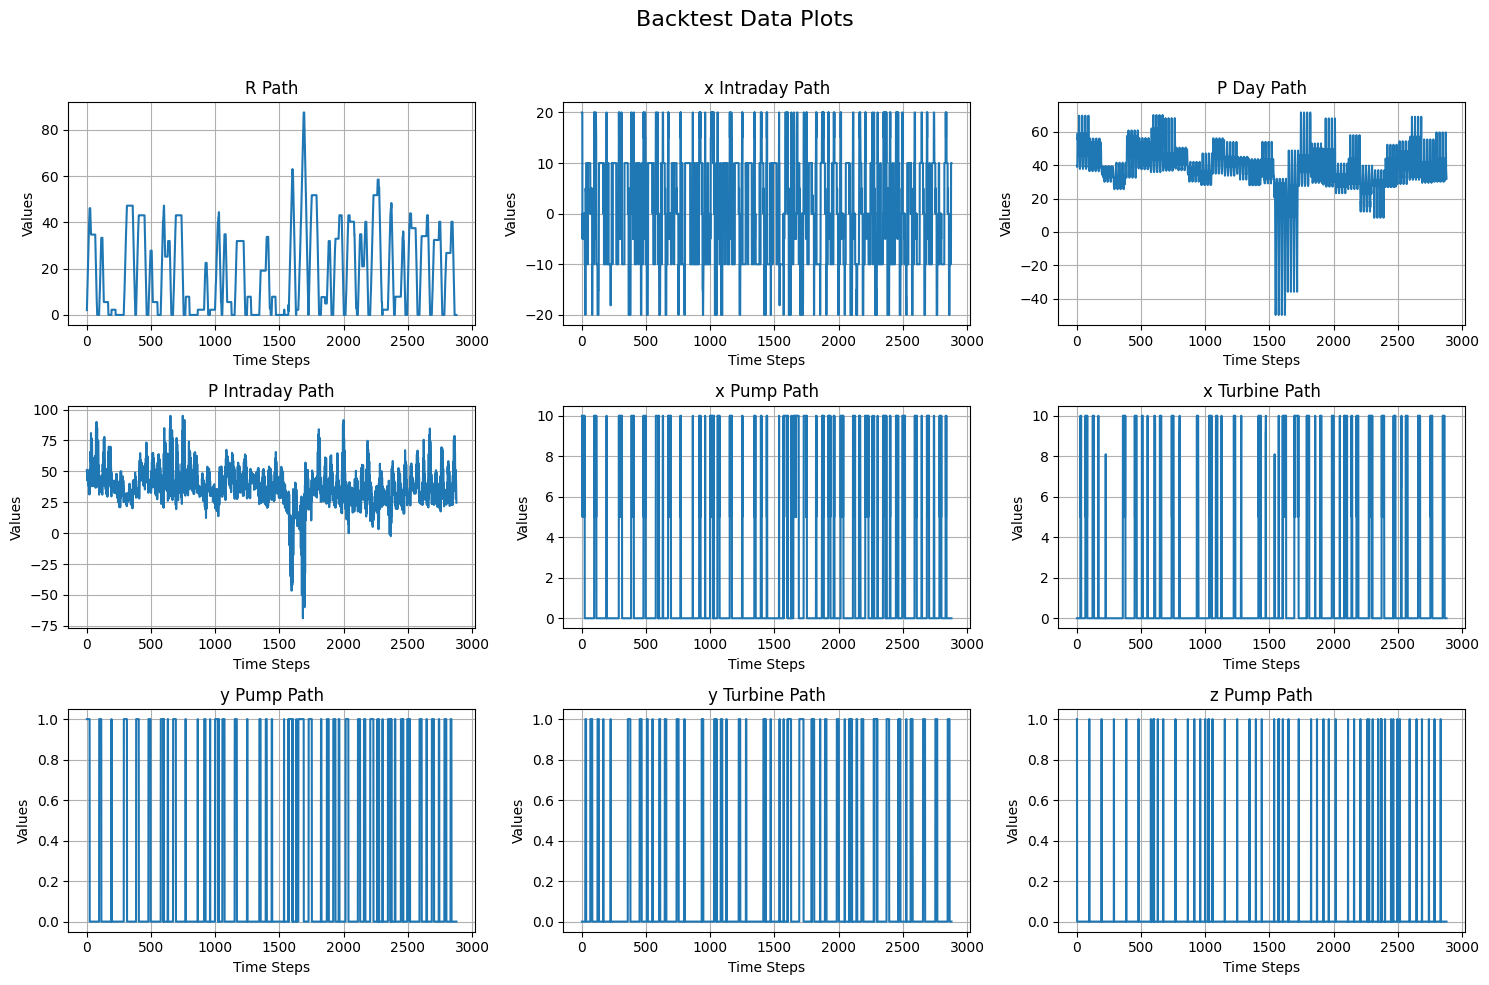

In [12]:
R_path = np.load("Results/BADP/BACKTEST_R_path.npy").ravel()
x_intraday_path = np.load("Results/BADP/BACKTEST_x_intraday_path.npy").ravel()
P_day_path = np.load("Results/BADP/BACKTEST_P_day_path.npy").ravel()
P_intraday_path = np.load("Results/BADP/BACKTEST_P_intraday_path.npy").ravel()
x_pump_path = np.load("Results/BADP/BACKTEST_x_pump_path.npy").ravel()
x_turbine_path = np.load("Results/BADP/BACKTEST_x_turbine_path.npy").ravel()
y_pump_path = np.load("Results/BADP/BACKTEST_y_pump_path.npy").ravel()
y_turbine_path = np.load("Results/BADP/BACKTEST_y_turbine_path.npy").ravel()
z_pump_path = np.load("Results/BADP/BACKTEST_z_pump_path.npy").ravel()

# Create a figure with multiple subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 10))
fig.suptitle("Backtest Data Plots", fontsize=16)

# Plot each array in a subplot
data = {
    "R Path": R_path,
    "x Intraday Path": x_intraday_path,
    "P Day Path": P_day_path,
    "P Intraday Path": P_intraday_path,
    "x Pump Path": x_pump_path,
    "x Turbine Path": x_turbine_path,
    "y Pump Path": y_pump_path,
    "y Turbine Path": y_turbine_path,
    "z Pump Path": z_pump_path,
}

# Iterate through data and subplots
for ax, (title, array) in zip(axs.flat, data.items()):
    ax.plot(array)
    ax.set_title(title)
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("Values")
    ax.grid(True)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Our Approach - NFQCA

The NFQCA (Neural Fitted Q-Continuous Action) approach builds upon the BAPD baseline by introducing improved action-space modeling and constraint handling through Quadratic Programming (QP) projections and policy regularization. Below is a brief description of key elements of our approach:

#### 1. **QP Projection (`qp_projection`)**
- Ensures that raw actions generated by the policy network respect predefined bounds and constraints.
- Solves a QP to minimize the distance between raw actions and feasible actions while enforcing equality, inequality, and bound constraints.
- Includes relaxation parameters for numerical stability when enforcing constraints.

#### 2. **Offline Data Loading**
- The `load_offline_data` function loads the offline data (day-ahead and intraday) for supervised learning and reinforcement learning.
- These datasets consist of state-action-reward-next-state tuples essential for training and evaluating Q-functions and policies.

#### 3. **Neural Network Models**
- **QNetwork**: Predicts Q-values for state-action pairs using a feedforward network, enabling the learning of value functions for day-ahead (`Q_DA`) and intraday (`Q_ID`) markets.
- **PolicyDA**: Represents the day-ahead policy, constrained to lie within specific bounds using a sigmoid transformation.
- **PolicyID**: Defines the intraday policy with complex constraints enforced by combining QP-based projections and penalty-based learning mechanisms.

#### 4. **Constraint Penalty Enforcement**
- The `update_policy_id_with_penalty` function penalizes actions that violate operational constraints during policy optimization.
- Leverages a batch-constraint generation function (`build_constraints_batch`) for efficient computation.

#### 5. **Dual Policy Optimization**
- **Day-Ahead Optimization**: Focuses on optimizing actions for strategic, long-term decisions based on day-ahead price forecasts.
- **Intraday Optimization**: Refines decisions based on real-time intraday price updates, incorporating tighter operational constraints.

#### 6. **Training Process**
- Updates Q-functions (`Q_DA` and `Q_ID`) using Bellman targets derived from rewards and next-step Q-values.
- Trains policies (`PolicyDA` and `PolicyID`) to maximize their respective Q-functions while adhering to operational constraints.
- Uses a soft-update mechanism to stabilize the learning of target networks for both Q-functions.

#### Improvements were made using our NFQCA approach by incorporating:
- Robust constraint handling.
- Enhanced action representation through QP projections.
- Dual policy optimization tailored for hierarchical decision-making.

### Architecture

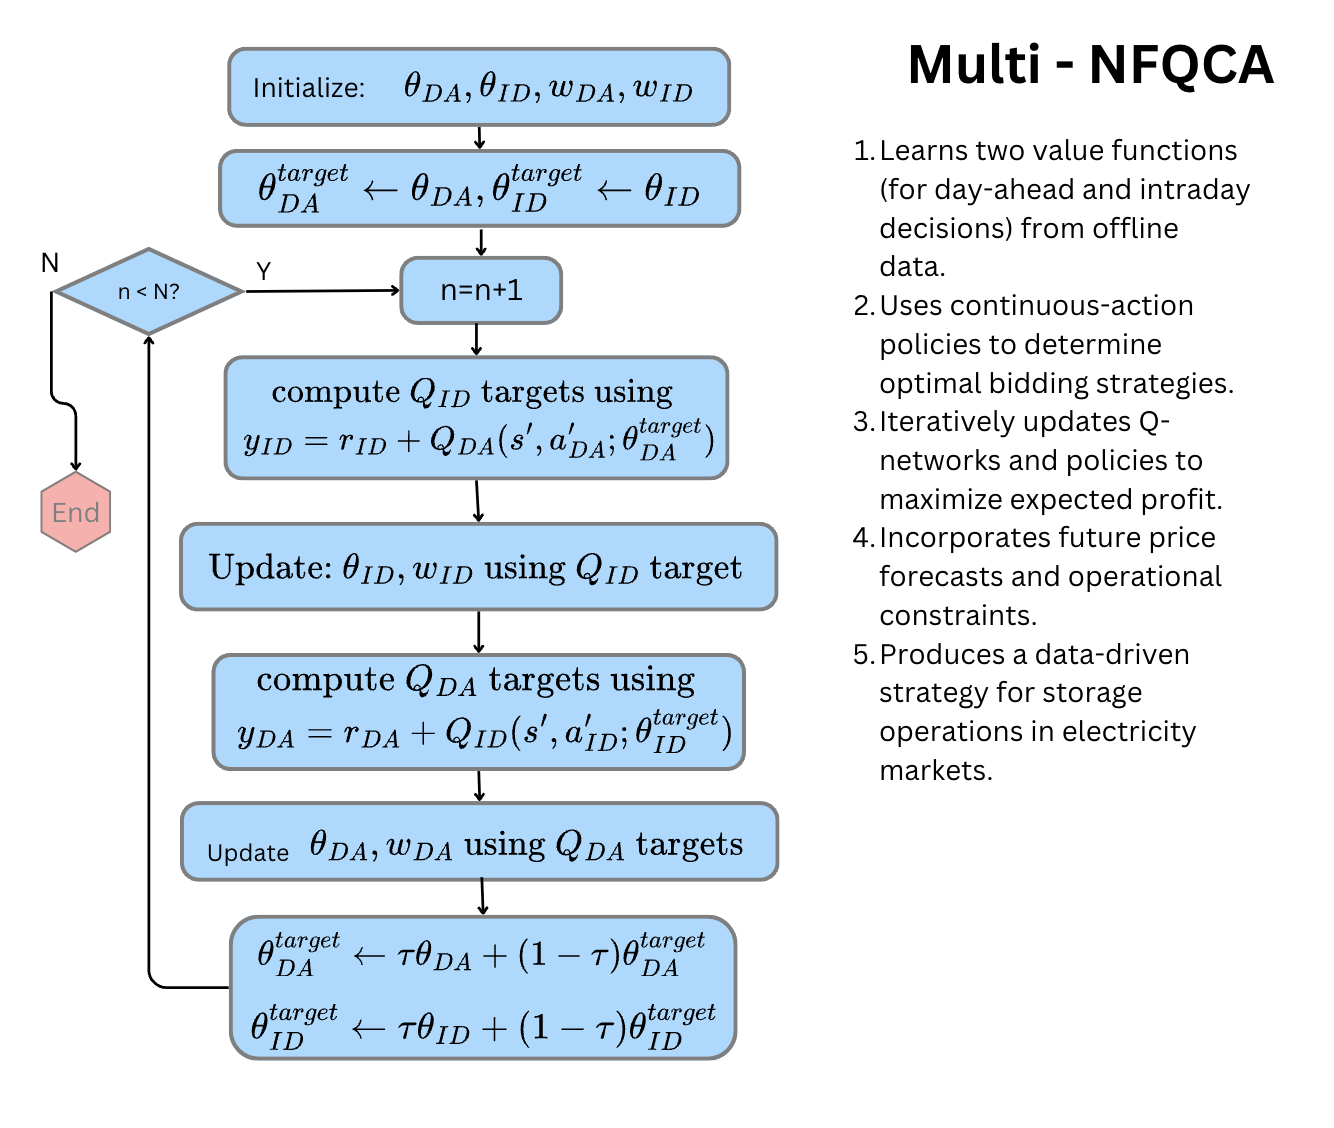

### Define Q and Policy networks

In [13]:
# Bounds for PolicyID
NEG_INF = -1e8
POS_INF = 1e8

# Network Definitions
class QNetwork(nn.Module):
    """
    A simple Q-network that takes continuous states and actions as inputs
    and outputs a scalar Q-value.
    """

    state_dim: int
    action_dim: int
    hidden_dim: int = 256

    @nn.compact
    def __call__(self, state: jnp.ndarray, action: jnp.ndarray) -> jnp.ndarray:
        x = jnp.concatenate([state, action.astype(jnp.float32)], axis=-1)
        x = nn.Dense(self.hidden_dim)(x)
        x = nn.relu(x)
        x = nn.Dense(self.hidden_dim)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x

class PolicyDA(nn.Module):
    """
    Policy network for the Day-Ahead scenario with bounded continuous actions.
    Actions are scaled via a sigmoid to fit within [lb, ub].
    """

    ub: float
    lb: float
    state_dim: int
    action_dim: int
    hidden_dim: int = 256

    @nn.compact
    def __call__(self, state: jnp.ndarray) -> jnp.ndarray:
        x = nn.Dense(self.hidden_dim)(state)
        x = nn.relu(x)
        x = nn.Dense(self.hidden_dim)(x)
        x = nn.relu(x)
        actions = nn.Dense(self.action_dim)(x)
        # Scale to [lb, ub]
        actions = self.lb + (self.ub - self.lb) * nn.sigmoid(actions)
        return actions

class PolicyID(nn.Module):
    """
    Policy network for the Intraday scenario with QP-based projection to enforce constraints.
    """

    sim_params: SimulationParams  # Include simulation parameters
    lb: jnp.ndarray
    ub: jnp.ndarray
    state_dim: int
    action_dim: int
    hidden_dim: int = 256

    def setup(self):
        # Precompute masks as numpy boolean arrays (static)
        self.bounded_mask_np = ((self.lb > NEG_INF) & (self.ub < POS_INF))
        self.lower_bounded_mask_np = ((self.lb > NEG_INF) & (self.ub == POS_INF))
        self.upper_bounded_mask_np = ((self.lb == NEG_INF) & (self.ub < POS_INF))
        self.unbounded_mask_np = ((self.lb == NEG_INF) & (self.ub == POS_INF))

        # Convert to JAX boolean arrays
        self.bounded_mask = jnp.array(self.bounded_mask_np, dtype=bool)
        self.lower_bounded_mask = jnp.array(self.lower_bounded_mask_np, dtype=bool)
        self.upper_bounded_mask = jnp.array(self.upper_bounded_mask_np, dtype=bool)
        self.unbounded_mask = jnp.array(self.unbounded_mask_np, dtype=bool)


    @nn.compact
    def __call__(self, state: jnp.ndarray) -> jnp.ndarray:
        """
        Forward pass of the PolicyID network with efficient action bounding.

        Args:
            state: Input state, shape (batch_size, state_dim)

        Returns:
            Projected actions, shape (batch_size, action_dim)
        """
        # 1. Neural Network to generate raw actions
        x = nn.Dense(self.hidden_dim)(state)
        x = nn.relu(x)
        x = nn.Dense(self.hidden_dim)(x)
        x = nn.relu(x)
        x = nn.Dense(self.hidden_dim)(x)
        x = nn.relu(x)

        raw_actions = nn.Dense(self.action_dim)(x)  # Shape: (batch_size, action_dim)

        # 2. Apply transformations based on mask types using jnp.where

        # a. Fully Bounded: [lb, ub]
        bounded_actions = self.lb + (self.ub - self.lb) * nn.sigmoid(raw_actions)
        actions = jnp.where(self.bounded_mask, bounded_actions, raw_actions)

        # b. Lower Bounded Only: [lb, +inf)
        lower_bounded_actions = self.lb + nn.softplus(raw_actions)
        actions = jnp.where(self.lower_bounded_mask, lower_bounded_actions, actions)

        # c. Upper Bounded Only: (-inf, ub]
        upper_bounded_actions = self.ub - nn.softplus(raw_actions)
        actions = jnp.where(self.upper_bounded_mask, upper_bounded_actions, actions)

        # d. Unbounded: (-inf, +inf) - already set to raw_actions

        return actions


### Helper functions for NFQCA

In [14]:
def load_offline_data(
    path: str,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Loads offline dataset from a pickle file. The file is expected to contain a dictionary
    with keys: "state", "action", "reward", "next_state". Each value should be a Series
    or array-like from which we can extract arrays.

    Returns:
        states, actions, rewards, next_states
    """
    with open(path, "rb") as f:
        df = pkl.load(f)
    states = np.stack(df["state"].values)
    actions = np.stack(df["action"].values)
    rewards = df["reward"].values
    next_states = np.stack(df["next_state"].values)
    return states, actions, rewards, next_states

def batch_iter(
    data: tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray],
    batch_size: int,
    shuffle: bool = True,
):
    """
    Generator that yields mini-batches of data.
    """
    states, actions, rewards, next_states = data
    N = len(states)
    indices = np.arange(N)
    if shuffle:
        np.random.shuffle(indices)
    for start in range(0, N, batch_size):
        idx = indices[start : start + batch_size]
        yield (states[idx], actions[idx], rewards[idx], next_states[idx])

def mse_loss(pred: jnp.ndarray, target: jnp.ndarray) -> jnp.ndarray:
    return jnp.mean((pred - target) ** 2)

def soft_update(target_params, online_params, tau=0.005):
    return jax.tree_util.tree_map(
        lambda tp, op: tp * (1 - tau) + op * tau, target_params, online_params
    )


### Load data

In [15]:
# Load day-ahead and intraday data
da_data = load_offline_data("Data/offline_dataset_day_ahead.pkl")
id_data = load_offline_data("Data/offline_dataset_intraday.pkl")

### Bounds for Intraday

In [16]:
lb_id = np.concatenate(
    [
        np.zeros(96),  # bounded
        NEG_INF * np.ones(96),  # unbounded (lower bound ~ -inf)
        np.zeros(96 * 10),  # bounded
    ]
).astype(np.float32)

ub_id = np.concatenate(
    [
        sim_params.Rmax * np.ones(96),  # bounded
        POS_INF * np.ones(96 * 7),  # unbounded (upper bound ~ inf)
        np.ones(96 * 4),  # bounded
    ]
).astype(np.float32)

# After defining lb_id and ub_id
total_masks = (
    ((lb_id > NEG_INF) & (ub_id < POS_INF)).sum() +
    ((lb_id > NEG_INF) & (ub_id == POS_INF)).sum() +
    ((lb_id == NEG_INF) & (ub_id < POS_INF)).sum() +
    ((lb_id == NEG_INF) & (ub_id == POS_INF)).sum()
)

assert total_masks == lb_id.shape[0], \
    f"Sum of all masks ({total_masks}) does not equal action_dim ({lb_id.shape[0]})"

### Initialize Q and Policy networks

In [17]:
key = jax.random.PRNGKey(0)
da_key, id_key, pda_key, pid_key = jax.random.split(key, 4)

q_da_model = QNetwork(state_dim=842, action_dim=24)
q_id_model = QNetwork(state_dim=890, action_dim=1152)
policy_da_model = PolicyDA(
    ub=sim_params.x_max_pump, lb=-sim_params.x_max_turbine, state_dim=842, action_dim=24
)
policy_id_model = PolicyID(
    sim_params=sim_params,
    lb=jnp.array(lb_id),
    ub=jnp.array(ub_id),
    state_dim=890,
    action_dim=1152,
)

dummy_s_da = jnp.ones((1, 842))
dummy_a_da = jnp.ones((1, 24), dtype=jnp.float32)
dummy_s_id = jnp.ones((1, 890))
dummy_a_id = jnp.ones((1, 1152), dtype=jnp.float32)

q_da_params = q_da_model.init(da_key, dummy_s_da, dummy_a_da)
q_id_params = q_id_model.init(id_key, dummy_s_id, dummy_a_id)
policy_da_params = policy_da_model.init(pda_key, dummy_s_da)
policy_id_params = policy_id_model.init(pid_key, dummy_s_id)

q_da_target_params = q_da_params
q_id_target_params = q_id_params

# Optimizers
q_learning_rate = 1e-4
policy_learning_rate = 1e-5

q_da_opt = optax.adam(q_learning_rate)
q_id_opt = optax.adam(q_learning_rate)
policy_da_opt = optax.adam(policy_learning_rate)
policy_id_opt = optax.adam(policy_learning_rate)

q_da_opt_state = q_da_opt.init(q_da_params)
q_id_opt_state = q_id_opt.init(q_id_params)
policy_da_opt_state = policy_da_opt.init(policy_da_params)
policy_id_opt_state = policy_id_opt.init(policy_id_params)

gamma = 0.99
batch_size = 256
num_epochs = 50

In [18]:
@jax.jit
def update_q_id(
    q_id_params,
    q_id_opt_state,
    q_id_target_params,
    q_da_target_params,
    policy_da_params,
    s_id,
    a_id,
    r_id,
    s_da_next,
):
    """
    Update Q_ID by fitting to the Bellman target:
    Q_ID(s,a) -> r_ID + gamma * Q_DA(s', policy_DA(s'))
    """
    next_da_actions = policy_da_model.apply(policy_da_params, s_da_next)
    q_da_values = q_da_model.apply(q_da_target_params, s_da_next, next_da_actions)
    q_target_id = r_id + gamma * q_da_values

    def loss_fn(params):
        q_estimate = q_id_model.apply(params, s_id, a_id)
        return mse_loss(q_estimate, q_target_id), q_estimate

    grads, q_estimate = jax.grad(loss_fn, has_aux=True)(q_id_params)
    updates, q_id_opt_state_new = q_id_opt.update(grads, q_id_opt_state)
    q_id_params_new = optax.apply_updates(q_id_params, updates)
    return q_id_params_new, q_id_opt_state_new, q_estimate

@jax.jit
def update_q_da(
    q_da_params,
    q_da_opt_state,
    q_da_target_params,
    q_id_target_params,
    policy_id_params,
    s_da,
    a_da,
    r_da,
    s_id_next,
):
    """
    Update Q_DA by fitting to the Bellman target:
    Q_DA(s,a) -> r_DA + gamma * Q_ID(s', policy_ID(s'))
    """
    next_id_actions = policy_id_model.apply(policy_id_params, s_id_next)
    q_id_values = q_id_model.apply(q_id_target_params, s_id_next, next_id_actions)
    q_target_da = r_da + gamma * q_id_values

    def loss_fn(params):
        q_da_values = q_da_model.apply(params, s_da, a_da)
        return mse_loss(q_da_values, q_target_da), q_da_values

    grads, q_da_values = jax.grad(loss_fn, has_aux=True)(q_da_params)
    updates, q_da_opt_state_new = q_da_opt.update(grads, q_da_opt_state)
    q_da_params_new = optax.apply_updates(q_da_params, updates)
    return q_da_params_new, q_da_opt_state_new, q_da_values

@jax.jit
def update_policy_da(policy_da_params, policy_da_opt_state, q_da_params, s_da):
    """
    Update Policy_DA by maximizing Q_DA(s, policy_DA(s)).
    """

    def loss_fn(params):
        a_da = policy_da_model.apply(params, s_da)
        q_values = q_da_model.apply(q_da_params, s_da, a_da)
        return -jnp.mean(q_values)

    grads = jax.grad(loss_fn)(policy_da_params)
    updates, policy_da_opt_state_new = policy_da_opt.update(grads, policy_da_opt_state)
    policy_da_params_new = optax.apply_updates(policy_da_params, updates)
    return policy_da_params_new, policy_da_opt_state_new

@jax.jit
def update_policy_id(policy_id_params, policy_id_opt_state, q_id_params, s_id):
    """
    Update Policy_ID by maximizing Q_ID(s, policy_ID(s)).
    """

    def loss_fn(params):
        a_id = policy_id_model.apply(params, s_id)
        q_values = q_id_model.apply(q_id_params, s_id, a_id)
        return -jnp.mean(q_values)

    grads = jax.grad(loss_fn)(policy_id_params)
    updates, policy_id_opt_state_new = policy_id_opt.update(grads, policy_id_opt_state)
    policy_id_params_new = optax.apply_updates(policy_id_params, updates)
    return policy_id_params_new, policy_id_opt_state_new

@partial(jax.jit, static_argnums=(4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15))
def update_policy_id_with_penalty(
    policy_id_params,
    policy_id_opt_state,
    q_id_params,
    states_id,
    Delta_ti,
    beta_pump,
    beta_turbine,
    c_pump_up,
    c_pump_down,
    c_turbine_up,
    c_turbine_down,
    x_min_pump,
    x_max_pump,
    x_min_turbine,
    x_max_turbine,
    Rmax,
):
    """
    Update Policy_ID by maximizing Q_ID(s, policy_ID(s)) with penalty for constraint violations.
    """

    def loss_fn(params):
        a_id = policy_id_model.apply(params, states_id)
        q_values = q_id_model.apply(q_id_params, states_id, a_id)

        # Compute constraints
        A, b, Aeq, beq, lb, ub = build_constraints_batch(
            states_id,
            Delta_ti,
            beta_pump,
            beta_turbine,
            c_pump_up,
            c_pump_down,
            c_turbine_up,
            c_turbine_down,
            x_min_pump,
            x_max_pump,
            x_min_turbine,
            x_max_turbine,
            Rmax,
        )
        batch_size = A.shape[0]
        action_size = a_id.shape[-1]
        relaxation = 1e2

        # Create identity matrix with batch dimension
        I = jnp.eye(action_size)
        I = jnp.expand_dims(I, axis=0)  # Shape: (1, action_size, action_size)
        I = jnp.tile(I, (batch_size, 1, 1))  # Shape: (batch_size, action_size, action_size)

        # # Concatenate all constraints
        A = jnp.concatenate([A, Aeq, -Aeq], axis=1)
        b = jnp.concatenate([b, beq + relaxation, -beq + relaxation], axis=1)


        # Penalty for A * x <= b
        Ax = jnp.einsum("bkc,bc->bk", A, a_id)  # Shape: (batch_size, num_constraints)
        penalty_ineq = jnp.maximum(Ax - b, 0.0)

        # Aggregate penalties
        penalty = jnp.sum(penalty_ineq**2)

        # Total loss
        return -jnp.mean(q_values) + penalty

    grads = jax.grad(loss_fn)(policy_id_params)
    updates, policy_id_opt_state_new = policy_id_opt.update(grads, policy_id_opt_state)
    policy_id_params_new = optax.apply_updates(policy_id_params, updates)
    return policy_id_params_new, policy_id_opt_state_new


## Training loop for Multi-NFQCA

In [19]:
for epoch in range(num_epochs):
    # Train Q_ID and Policy_ID
    for s_id, a_id, r_id, s_da_next in batch_iter(id_data, batch_size):
        s_id = jnp.array(s_id, dtype=jnp.float32)
        a_id = jnp.array(a_id, dtype=jnp.float32)
        r_id = jnp.array(r_id, dtype=jnp.float32).reshape(-1, 1)
        s_da_next = jnp.array(s_da_next, dtype=jnp.float32)

        # Update Q_ID
        for i in range(5):
            q_id_params, q_id_opt_state, _ = update_q_id(
                q_id_params,
                q_id_opt_state,
                q_id_target_params,
                q_da_target_params,
                policy_da_params,
                s_id,
                a_id,
                r_id,
                s_da_next,
            )

        # Update Policy_ID with penalties
        policy_id_params, policy_id_opt_state = update_policy_id_with_penalty(
            policy_id_params,
            policy_id_opt_state,
            q_id_params,
            s_id,
            sim_params.Delta_ti,
            sim_params.beta_pump,
            sim_params.beta_turbine,
            sim_params.c_pump_up,
            sim_params.c_pump_down,
            sim_params.c_turbine_up,
            sim_params.c_turbine_down,
            sim_params.x_min_pump,
            sim_params.x_max_pump,
            sim_params.x_min_turbine,
            sim_params.x_max_turbine,
            sim_params.Rmax,
        )

    # Train Q_DA and Policy_DA
    for s_da, a_da, r_da, s_id_next in batch_iter(da_data, batch_size):
        s_da = jnp.array(s_da, dtype=jnp.float32)
        a_da = jnp.array(a_da, dtype=jnp.float32)
        r_da = jnp.array(r_da, dtype=jnp.float32).reshape(-1, 1)
        s_id_next = jnp.array(s_id_next, dtype=jnp.float32)

        # Update Q_DA
        for i in range(5):
            q_da_params, q_da_opt_state, _ = update_q_da(
                q_da_params,
                q_da_opt_state,
                q_da_target_params,
                q_id_target_params,
                policy_id_params,
                s_da,
                a_da,
                r_da,
                s_id_next,
            )

        # Update Policy_DA
        policy_da_params, policy_da_opt_state = update_policy_da(
            policy_da_params, policy_da_opt_state, q_da_params, s_da
        )

    # Soft updates of target networks
    q_da_target_params = soft_update(q_da_target_params, q_da_params)
    q_id_target_params = soft_update(q_id_target_params, q_id_params)

    print(f"Epoch {epoch+1}/{num_epochs} completed.")


Epoch 1/50 completed.
Epoch 2/50 completed.
Epoch 3/50 completed.
Epoch 4/50 completed.
Epoch 5/50 completed.
Epoch 6/50 completed.
Epoch 7/50 completed.
Epoch 8/50 completed.
Epoch 9/50 completed.
Epoch 10/50 completed.
Epoch 11/50 completed.
Epoch 12/50 completed.
Epoch 13/50 completed.
Epoch 14/50 completed.
Epoch 15/50 completed.
Epoch 16/50 completed.
Epoch 17/50 completed.
Epoch 18/50 completed.
Epoch 19/50 completed.
Epoch 20/50 completed.
Epoch 21/50 completed.
Epoch 22/50 completed.
Epoch 23/50 completed.
Epoch 24/50 completed.
Epoch 25/50 completed.
Epoch 26/50 completed.
Epoch 27/50 completed.
Epoch 28/50 completed.
Epoch 29/50 completed.
Epoch 30/50 completed.
Epoch 31/50 completed.
Epoch 32/50 completed.
Epoch 33/50 completed.
Epoch 34/50 completed.
Epoch 35/50 completed.
Epoch 36/50 completed.
Epoch 37/50 completed.
Epoch 38/50 completed.
Epoch 39/50 completed.
Epoch 40/50 completed.
Epoch 41/50 completed.
Epoch 42/50 completed.
Epoch 43/50 completed.
Epoch 44/50 complete

## Evaluating Learned Policies with NFQCA

We evaluate the performance of learned policies (day-ahead and intra-day) under the NFQCA framework using a held-out test dataset. It simulates a day-ahead and intraday market environment while considering operational constraints and energy market dynamics.

In [20]:
def eval_learned_policy(policy_id_model, policy_da_model, policy_id_params, policy_da_params):
    M=1
    T=30
    D=7
    Season='Summer'

    Q_mult=1.2
    Q_fix=3
    Q_start_pump=15
    Q_start_turbine=15

    c_grid_fee=5/4
    Delta_ti=0.25
    Delta_td=1.0

    t_ramp_pump_up=2/60
    t_ramp_pump_down=2/60
    t_ramp_turbine_up=2/60
    t_ramp_turbine_down=2/60

    seed=2
    np.random.seed(seed)

    P_day_mat = loadmat(os.path.join("Data", f"P_day_ahead_test_all.mat"))
    P_intraday_mat = loadmat(os.path.join("Data", f"P_intraday_test_all.mat"))

    P_day_0 = P_day_mat['P_day_0'].flatten()
    P_intraday_0 = P_intraday_mat['P_intraday_0'].flatten()

    R_0=0
    x0_0=0
    V = np.zeros((M,1))

    R_path=np.zeros((M,96*T))
    x_intraday_path=np.zeros((M,96*T))
    P_day_path=np.zeros((M,96*T))
    P_intraday_path=np.zeros((M,96*T))
    x_pump_path=np.zeros((M,96*T))
    x_turbine_path=np.zeros((M,96*T))
    y_pump_path=np.zeros((M,96*T))
    y_turbine_path=np.zeros((M,96*T))
    z_pump_path=np.zeros((M,96*T))
    z_turbine_path=np.zeros((M,96*T))

    # Enviroment trackers
    storage_track = []
    storage_track.append(R_0)

    for m in range(M):
        R = R_0
        x0 = x0_0
        P_day = P_day_0[: 24 * D].copy()
        P_intraday = P_intraday_0[: 96 * D].copy()

        P_day_sim = P_day_0[: 24 * D].copy()
        P_intraday_sim = P_intraday_0[: 96 * D].copy()

        C=0
        for t_i in range(T):
            mu_day,_ = sample_price_day(P_day_sim, t_i, Season)
            mu_intraday,_ = sample_price_intraday(np.concatenate([mu_day,P_day_sim]), P_intraday_sim, t_i, Season)

            P_day_next = np.concatenate([mu_day, P_day[:-24].copy()])
            P_intraday_next = np.concatenate([mu_intraday, P_intraday[:-96].copy()])

            q_pump_up=(abs(mu_intraday)/Q_mult - Q_fix)*t_ramp_pump_up/2
            q_pump_down=(abs(mu_intraday)*Q_mult+Q_fix)*t_ramp_pump_down/2
            q_turbine_up=(abs(mu_intraday)*Q_mult+Q_fix)*t_ramp_turbine_up/2
            q_turbine_down=(abs(mu_intraday)/Q_mult - Q_fix)*t_ramp_turbine_down/2

            # Get day ahead initial state
            da_state = np.concatenate([[R], [x0], P_day, P_intraday])

            Wt_day = P_day_0[t_i * 24 : (t_i + 1) * 24].copy()
            day_path = np.tile(Wt_day, (4, 1))
            P_day_path[m, t_i * 96 : (t_i + 1) * 96] = day_path.flatten()

            # Get day ahead action from corresponding policy model
            xday_opt = policy_da_model.apply(policy_da_params, da_state)

            # Get initial state for intraday
            id_state = np.concatenate([da_state, xday_opt, Wt_day])

            # Get intraday action from corresponding policy model
            xid_opt = policy_id_model.apply(policy_id_params, id_state)

            # Extract results from x_opt2
            R_opt = xid_opt[:96].copy()
            xhq_opt = xid_opt[96:2*96].copy()

            Delta_pump_up = xid_opt[4*96:5*96].copy()
            Delta_pump_down = xid_opt[5*96:6*96].copy()
            Delta_turbine_up = xid_opt[6*96:7*96].copy()
            Delta_turbine_down = xid_opt[7*96:8*96].copy()

            x_pump = xid_opt[2*96:3*96].copy()
            x_turbine = xid_opt[3*96:4*96].copy()
            y_pump = xid_opt[8*96:9*96].copy()
            y_turbine = xid_opt[9*96:10*96].copy()
            z_pump = xid_opt[10*96:11*96].copy()
            z_turbine = xid_opt[11*96:12*96].copy()

            # Update paths
            R_path[m, t_i * 96 : (t_i + 1) * 96] = R_opt
            x_intraday_path[m, t_i * 96 : (t_i + 1) * 96] = xhq_opt
            x_pump_path[m, t_i * 96 : (t_i + 1) * 96] = x_pump
            x_turbine_path[m, t_i * 96 : (t_i + 1) * 96] = x_turbine
            y_pump_path[m, t_i * 96 : (t_i + 1) * 96] = y_pump
            y_turbine_path[m, t_i * 96 : (t_i + 1) * 96] = y_turbine
            z_pump_path[m, t_i * 96 : (t_i + 1) * 96] = z_pump
            z_turbine_path[m, t_i * 96 : (t_i + 1) * 96] = z_turbine

            Wt_intraday = P_intraday_0[t_i * 96 : (t_i + 1) * 96].copy()
            P_intraday_path[m, t_i*96:(t_i+1)*96] = Wt_intraday

            # Update q_ ramps with realized intraday prices
            q_pump_up = (np.abs(Wt_intraday)/Q_mult - Q_fix)*t_ramp_pump_up/2
            q_pump_down = (np.abs(Wt_intraday)*Q_mult+Q_fix)*t_ramp_pump_down/2
            q_turbine_up = (np.abs(Wt_intraday)*Q_mult+Q_fix)*t_ramp_turbine_up/2
            q_turbine_down = (np.abs(Wt_intraday)/Q_mult - Q_fix)*t_ramp_turbine_down/2

            # Update R, x0, P_day, P_intraday, P_day_sim, P_intraday_sim
            R = R_opt[-1].copy()
            x0 = x_pump[-1] - x_turbine[-1]
            P_day = np.concatenate([Wt_day, P_day[:-24].copy()])
            P_intraday = np.concatenate([Wt_intraday, P_intraday[:-96].copy()])
            P_day_sim = np.concatenate([Wt_day, P_day_sim[:-24].copy()])
            P_intraday_sim = np.concatenate([Wt_intraday, P_intraday_sim[:-96].copy()])

            # Update C
            C = C - Delta_td*np.dot(Wt_day, xday_opt) - np.sum(x_pump)*c_grid_fee \
                - Delta_ti*np.dot(Wt_intraday, xhq_opt) \
                + np.dot(q_pump_up, Delta_pump_up) - np.dot(q_pump_down, Delta_pump_down) \
                - np.dot(q_turbine_up, Delta_turbine_up) + np.dot(q_turbine_down, Delta_turbine_down) \
                - np.sum(z_pump)*Q_start_pump - np.sum(z_turbine)*Q_start_turbine

            # UPDATE TRACKERS
            storage_track.append(R)

        V[m] = C

    EV = np.mean(V)
    print(EV)

    # print backtest statistics :
    print("Backtest Statistics:")
    print("Mean Value: ", np.mean(V))
    print("Standard Deviation: ", np.std(V))
    print("Total Reward: ", np.sum(V))

    # save trackers
    # storage_track
    np.save("Results/NFQCA/BACKTEST_storage_track.npy", storage_track)

    # Save paths
    np.save("Results/NFQCA/BACKTEST_R_path.npy", R_path)
    np.save("Results/NFQCA/BACKTEST_x_intraday_path.npy", x_intraday_path)
    np.save("Results/NFQCA/BACKTEST_P_day_path.npy", P_day_path)
    np.save("Results/NFQCA/BACKTEST_P_intraday_path.npy", P_intraday_path)
    np.save("Results/NFQCA/BACKTEST_x_pump_path.npy", x_pump_path)
    np.save("Results/NFQCA/BACKTEST_x_turbine_path.npy", x_turbine_path)
    np.save("Results/NFQCA/BACKTEST_y_pump_path.npy", y_pump_path)
    np.save("Results/NFQCA/BACKTEST_y_turbine_path.npy", y_turbine_path)
    np.save("Results/NFQCA/BACKTEST_z_pump_path.npy", z_pump_path)
    np.save("Results/NFQCA/BACKTEST_z_turbine_path.npy", z_turbine_path)

## Results Visualization - NFQCA 

The plots below illustrate the performance of the NFQCA approach in managing energy storage and operational constraints. Key elements such as market prices, intraday actions, and pump/turbine operations are visualized, showcasing the model's ability to adapt dynamically to market signals and system constraints. This visualization highlights how the NFQCA policy efficiently balances energy resources while adhering to operational boundaries, improving upon baseline of the BAPD approach.

31403.75
Backtest Statistics:
Mean Value:  31403.75
Standard Deviation:  0.0
Total Reward:  31403.75


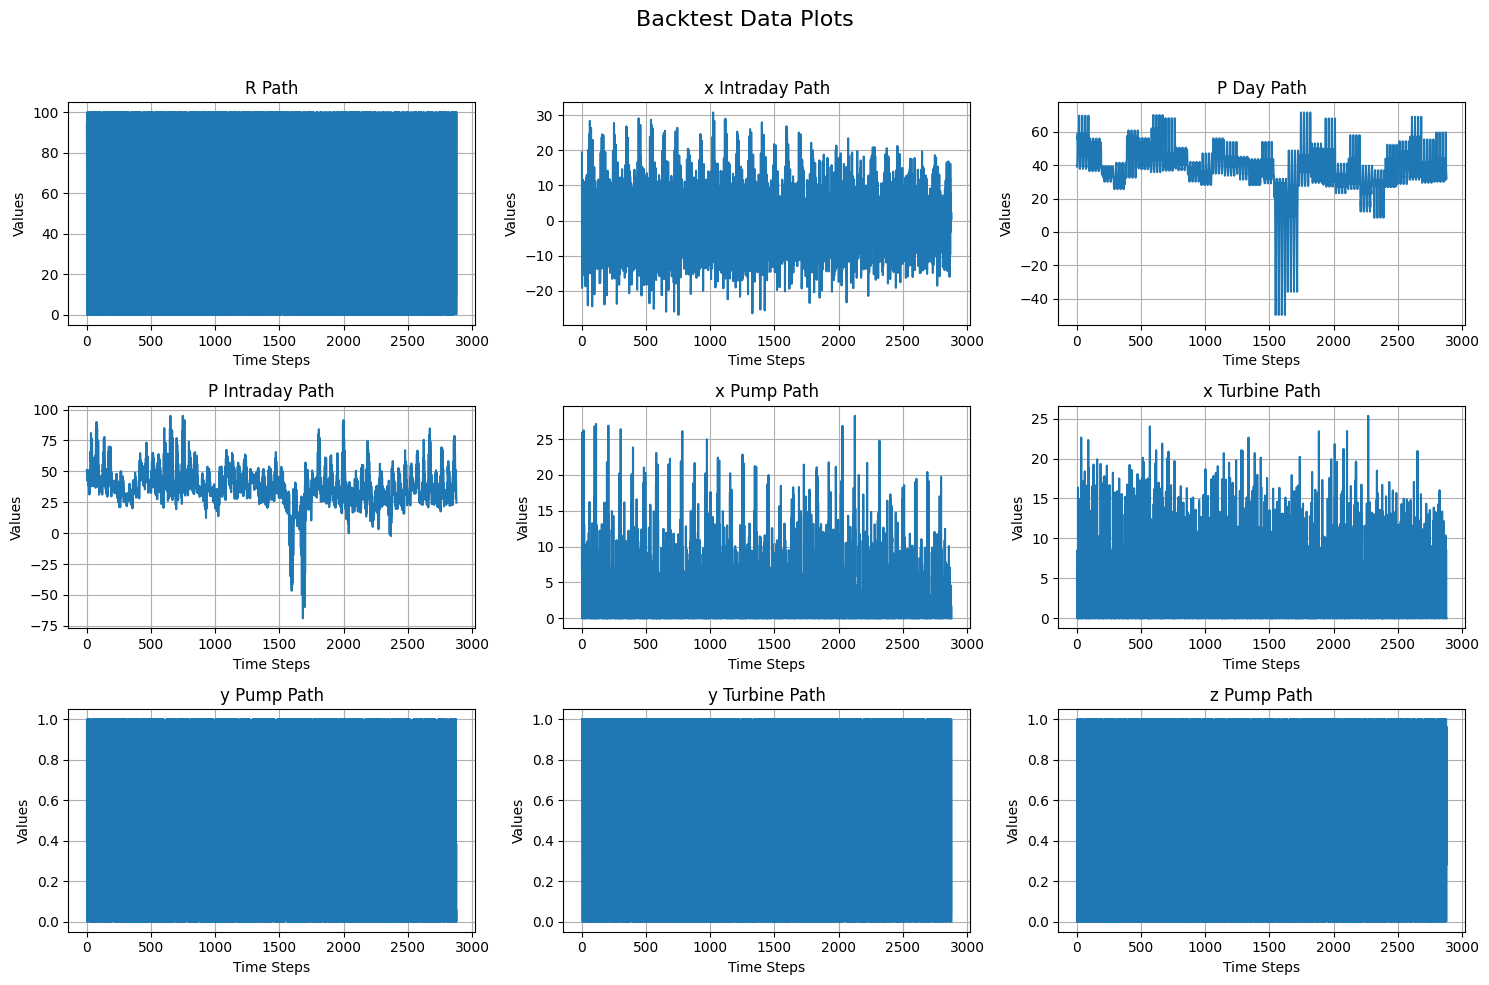

In [21]:
eval_learned_policy(
    policy_id_model, policy_da_model, policy_id_params, policy_da_params
)

R_path = np.load("Results/NFQCA/BACKTEST_R_path.npy").ravel()
x_intraday_path = np.load("Results/NFQCA/BACKTEST_x_intraday_path.npy").ravel()
P_day_path = np.load("Results/NFQCA/BACKTEST_P_day_path.npy").ravel()
P_intraday_path = np.load("Results/NFQCA/BACKTEST_P_intraday_path.npy").ravel()
x_pump_path = np.load("Results/NFQCA/BACKTEST_x_pump_path.npy").ravel()
x_turbine_path = np.load("Results/NFQCA/BACKTEST_x_turbine_path.npy").ravel()
y_pump_path = np.load("Results/NFQCA/BACKTEST_y_pump_path.npy").ravel()
y_turbine_path = np.load("Results/NFQCA/BACKTEST_y_turbine_path.npy").ravel()
z_pump_path = np.load("Results/NFQCA/BACKTEST_z_pump_path.npy").ravel()

# Create a figure with multiple subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 10))
fig.suptitle("Backtest Data Plots", fontsize=16)

# Plot each array in a subplot
data = {
    "R Path": R_path,
    "x Intraday Path": x_intraday_path,
    "P Day Path": P_day_path,
    "P Intraday Path": P_intraday_path,
    "x Pump Path": x_pump_path,
    "x Turbine Path": x_turbine_path,
    "y Pump Path": y_pump_path,
    "y Turbine Path": y_turbine_path,
    "z Pump Path": z_pump_path,
}

# Iterate through data and subplots
for ax, (title, array) in zip(axs.flat, data.items()):
    ax.plot(array)
    ax.set_title(title)
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("Values")
    ax.grid(True)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("Results/backtest_plots.png")

# Alternative Approaches Explored